# PXD015122
## AKT but not MYC promotes reactive oxygen species-mediated cell death in oxidative culture
[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD015122)

[Article link](https://journals.biologists.com/jcs/article/133/7/jcs239277/224851/AKT-but-not-MYC-promotes-reactive-oxygen-species)

In [2]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)

<module 'OxiAnalysis' from '/home/robbe/ionbot/OxiAnalysis.py'>

In [3]:
first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD015122_first.csv")
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].replace('0', 0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)


/tmp/ipykernel_3480783/4104437467.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD015122_first.csv")


In [4]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  470745
The amount of raw files that make up the master dataset is:  36


In [5]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [6]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,Constitutively active AKT,0,0,Galactose,0,Long-term,41902
1,Constitutively active AKT,0,0,Galactose,0,Short-term,65538
2,Constitutively active AKT,0,0,None,0,0,37524
3,Constitutively active MYC,0,0,Galactose,0,Long-term,59213
4,Constitutively active MYC,0,0,Galactose,0,Short-term,37992
5,Constitutively active MYC,0,0,None,0,0,72620
6,None,0,0,Galactose,0,Long-term,42708
7,None,0,0,Galactose,0,Short-term,63565
8,None,0,0,None,0,0,49683


### Conditions that will be compared

| N | Treatment | Treatment 2 | Treatment 3|
| - | ----------- | ----------- | -------- |
| 1 | AKT in Glucose | AKT in short-term Galactose | AKT in long-term Galactose |
| 2 | MYC in Glucose | MYC in short-term Galactose | MYC in long-term Galactose |
| 3 | None in Glucose | None in short-term Galactose | None in long-term Galactose |
| 4 | None | AKT | MYC |
| 5 | None in short-term Galactose | AKT in short-term Galactose | MYC in short-term Galactose |
| 6 | None in long-term Galactose | AKT in long-term Galactose | MYC in long-term Galactose |

In [35]:
AKT = first.loc[lambda first: (first["Oxidant treatment"] == "Constitutively active AKT") & (first["Secondary treatment"] == "None")]
AKTst = first.loc[lambda first: (first["Oxidant treatment"] == "Constitutively active AKT") & (first["Secondary treatment"] == "Galactose") & (first["Length of Secondary treatment (mins)"] == "Short-term")]
AKTlt = first.loc[lambda first: (first["Oxidant treatment"] == "Constitutively active AKT") & (first["Secondary treatment"] == "Galactose") & (first["Length of Secondary treatment (mins)"] == "Long-term")]
MYC = first.loc[lambda first: (first["Oxidant treatment"] == "Constitutively active MYC") & (first["Secondary treatment"] == "None")]
MYCst = first.loc[lambda first: (first["Oxidant treatment"] == "Constitutively active MYC") & (first["Secondary treatment"] == "Galactose") & (first["Length of Secondary treatment (mins)"] == "Short-term")]
MYClt = first.loc[lambda first: (first["Oxidant treatment"] == "Constitutively active MYC") & (first["Secondary treatment"] == "Galactose") & (first["Length of Secondary treatment (mins)"] == "Long-term")]
Control = first.loc[lambda first: (first["Oxidant treatment"] == "None") & (first["Secondary treatment"] == "None")]
Controlst = first.loc[lambda first: (first["Oxidant treatment"] == "None") & (first["Secondary treatment"] == "Galactose") & (first["Length of Secondary treatment (mins)"] == "Short-term")]
Controllt = first.loc[lambda first: (first["Oxidant treatment"] == "None") & (first["Secondary treatment"] == "Galactose") & (first["Length of Secondary treatment (mins)"] == "Long-term")]

## Comparison between the treatments
### 1) Constitutively active AKT in three conditions (glucose medium, short-term Galactose medium, long-term Galactose medium)

In [8]:
print("There are this many replicates of AKT treatment: {}".format(AKT["spectrum_file"].nunique()))
print("There are this many replicates of AKTst treatment: {}".format(AKTst["spectrum_file"].nunique()))
print("There are this many replicates of AKTlt treatment: {}".format(AKTlt["spectrum_file"].nunique()))

There are this many replicates of AKT treatment: 4
There are this many replicates of AKTst treatment: 4
There are this many replicates of AKTlt treatment: 4


In [9]:
AKTrep = OA.replicate_filter(AKT,2)
AKTstrep = OA.replicate_filter(AKTst,2)
AKTltrep = OA.replicate_filter(AKTlt,2)

In [10]:
print("The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: {}".format((AKTrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the AKTst treatment subset: {}".format((AKTstrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the AKTlt treatment subset: {}".format((AKTltrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: 3.919445647466436 %
The ratio of PSMs that contain an oxidative modification in the AKTst treatment subset: 5.028423533761612 %
The ratio of PSMs that contain an oxidative modification in the AKTlt treatment subset: 3.004059539918809 %


In [11]:
mrAKTrep = OA.modratios(AKTrep)
mrAKTstrep = OA.modratios(AKTst)
mrAKTltrep = OA.modratios(AKTlt)

In [12]:
modr_temp = pd.merge(mrAKTltrep, mrAKTstrep, on="Modification", suffixes=('_ltGal', '_stGal'))
modr = pd.merge(modr_temp, mrAKTrep, on="Modification")
modr = modr.rename(columns={'Ratios':'Ratios_Glu'})
modr = modr.drop(modr[(modr["Ratios_ltGal"] == 0) | (modr["Ratios_stGal"] == 0) | (modr["Ratios_Glu"] == 0)].index)
modr

,Modification,Ratios_ltGal,Ratios_stGal,Ratios_Glu
2,[35]Oxidation[S],0.000268,0.000283,0.000134
3,[35]Oxidation[Q],0.000060,0.000162,0.000269
7,[35]Oxidation[G],0.000298,0.000485,0.000269
8,[35]Oxidation[W],0.000745,0.000828,0.001611
21,[53]HNE[H],0.000149,0.000081,0.000269
23,[53]HNE[A],0.000149,0.000162,0.000269
33,[345]Trioxidation[C],0.000447,0.000727,0.000672
65,[378]Carboxyethyl[K],0.000030,0.000020,0.000269
74,[421]Sulfide[W],0.000447,0.000525,0.001075
76,[425]Dioxidation[C],0.000089,0.000121,0.000269


Note about the following graph: here only mods where included which had a non-0 value for all three conditions. This was done because otherwise the graph was very messy. Other projects this is not the case, then mods are included as soon as there is 1 non-0 value.

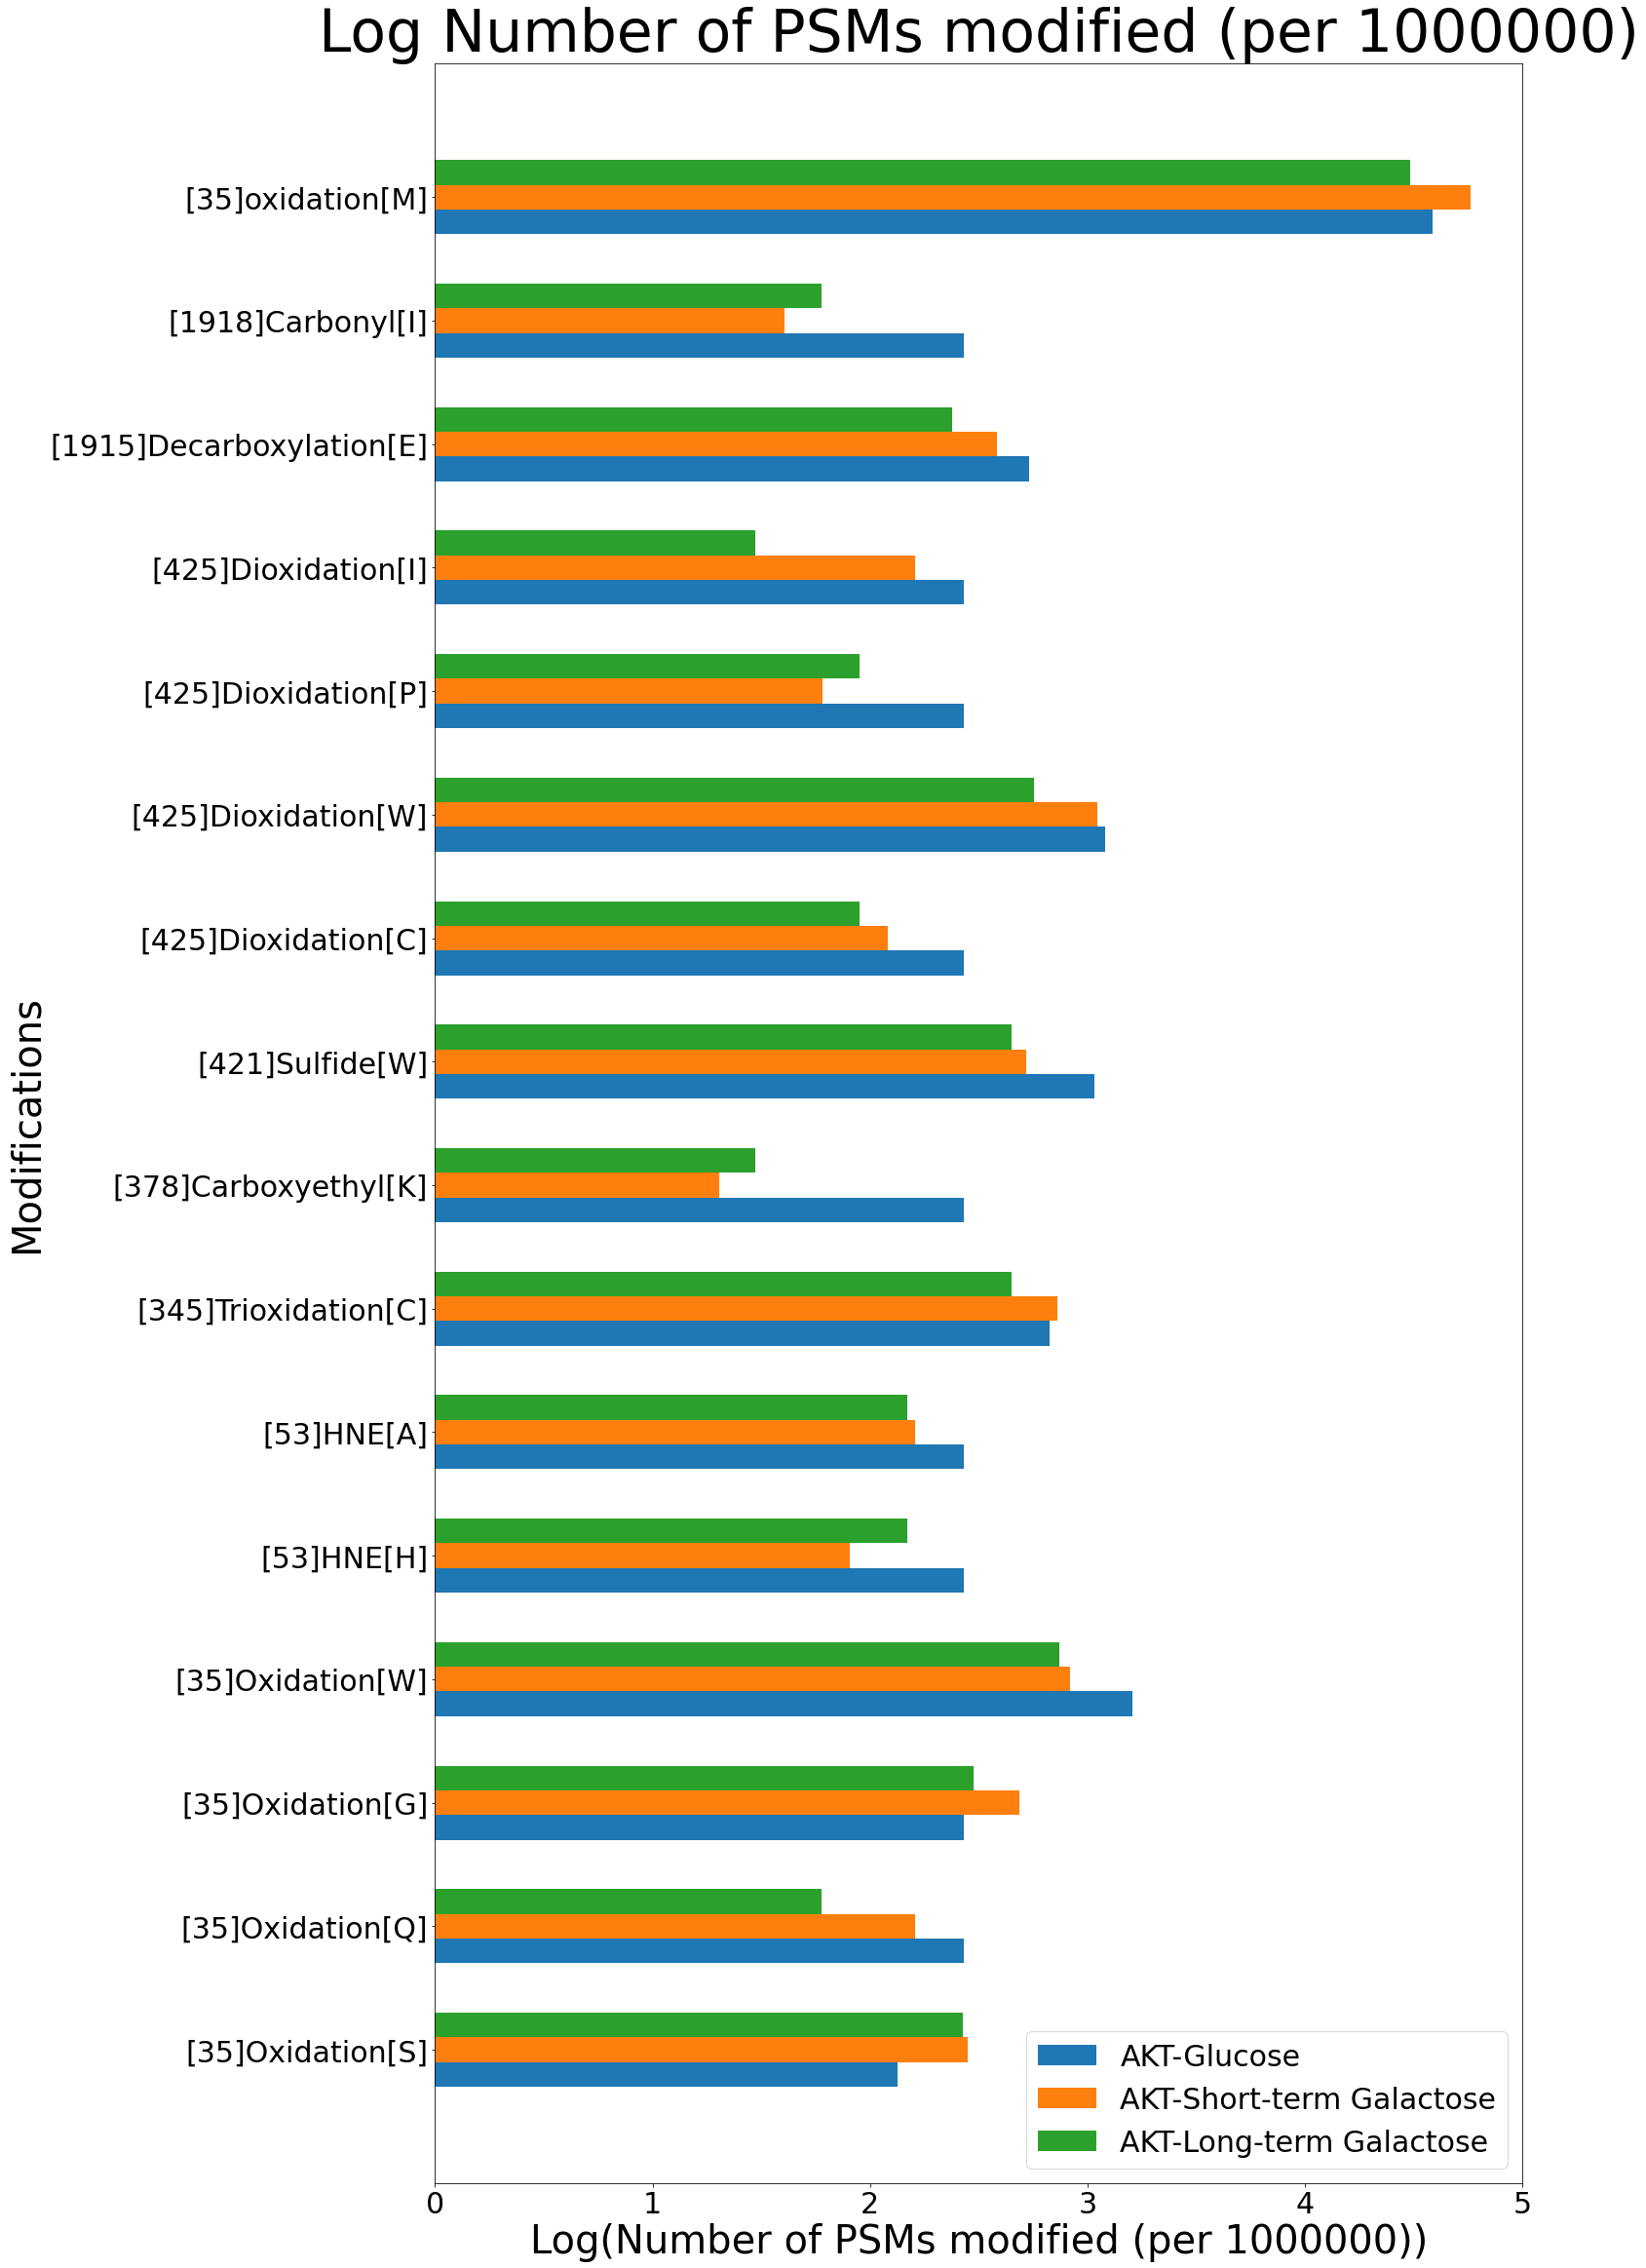

In [13]:
y = modr["Modification"]
xGlu = np.log10(modr['Ratios_Glu']*1000000)
xstGal = np.log10(modr['Ratios_stGal']*1000000)
xltGal = np.log10(modr['Ratios_ltGal']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'AKT-Glucose')
plt.barh(y_axis, xstGal, 0.2, label = 'AKT-Short-term Galactose')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'AKT-Long-term Galactose')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

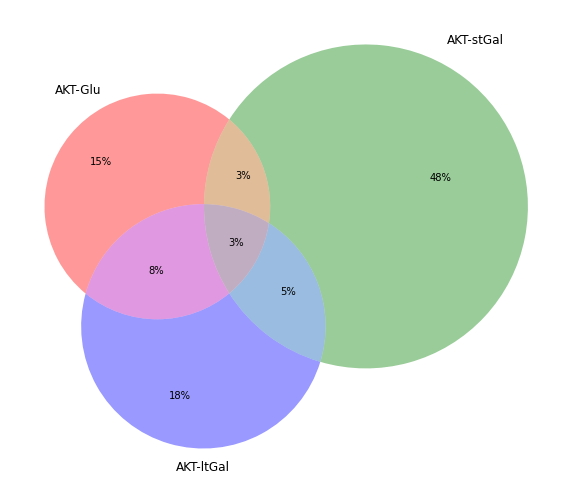

In [14]:
OA.condition_venn([AKTrep,AKTstrep,AKTltrep], ["AKT-Glu", "AKT-stGal", "AKT-ltGal"])

In [15]:
RPMAKT = OA.relative_PSM_modification(AKTrep)
RPMAKTst = OA.relative_PSM_modification(AKTstrep)
RPMAKTlt = OA.relative_PSM_modification(AKTltrep)

In [16]:
RPM = pd.merge(RPMAKT,RPMAKTst, on="Amino acid", suffixes=('_AKT','_AKTst'))
RPM = pd.merge(RPM, RPMAKTlt, on="Amino acid")
RPM = RPM.rename(columns={"Relative level of PSMs containing unmodified residue": "Relative level of PSMs containing unmodified residue_AKTlt"})
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_AKT,Relative level of PSMs containing unmodified residue_AKTst,Relative level of PSMs containing unmodified residue_AKTlt
0,A,0.998316,0.999305,0.997763
1,R,0.996830,0.998623,0.998976
2,N,0.989226,0.992295,0.991514
3,D,0.992172,0.993125,0.990653
4,C,0.025022,0.032637,0.032842
5,Q,0.990845,0.991742,0.987085
6,E,0.994979,0.993308,0.994736
7,G,0.998888,0.999550,0.999114
8,H,0.997434,0.996583,0.994864
9,I,0.999500,0.999395,0.999797


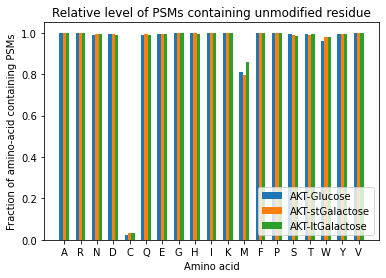

In [17]:
x = RPM["Amino acid"]
xGlu = RPM["Relative level of PSMs containing unmodified residue_AKT"]
xst = RPM['Relative level of PSMs containing unmodified residue_AKTst']
xlt = RPM['Relative level of PSMs containing unmodified residue_AKTlt']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'AKT-Glucose')
plt.bar(x_axis, xst, 0.2, label = 'AKT-stGalactose')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'AKT-ltGalactose')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

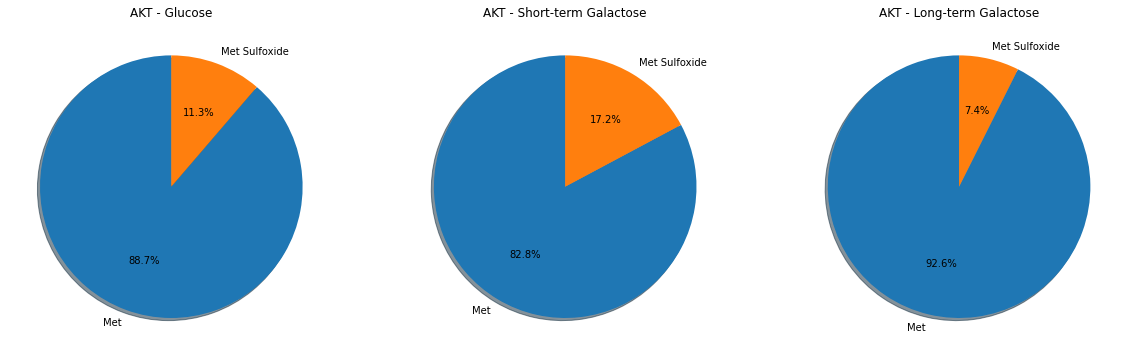

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(AKTrep, ax1)
OA.methionine_overview(AKTstrep, ax2)
OA.methionine_overview(AKTltrep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("AKT - Glucose")
ax2.set_title("AKT - Short-term Galactose")
ax3.set_title("AKT - Long-term Galactose")
plt.show()

### 2) Constitutively active MYC in three conditions (Glucose medium, short-term Galactose medium, long-term Galactose medium)

In [19]:
print("There are this many replicates of each treatment: {}".format(MYC["spectrum_file"].nunique()))
print("There are this many replicates of each treatment: {}".format(MYCst["spectrum_file"].nunique()))
print("There are this many replicates of each treatment: {}".format(MYClt["spectrum_file"].nunique()))

There are this many replicates of each treatment: 4
There are this many replicates of each treatment: 4
There are this many replicates of each treatment: 4


In [20]:
MYCrep = OA.replicate_filter(MYC,2)
MYCstrep = OA.replicate_filter(MYCst,2)
MYCltrep = OA.replicate_filter(MYClt,2)

In [22]:
print("The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: {}".format((MYCrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the MYCst treatment subset: {}".format((MYCstrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the MYClt treatment subset: {}".format((MYCltrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: 3.823149994136273 %
The ratio of PSMs that contain an oxidative modification in the MYCst treatment subset: 4.525823285945655 %
The ratio of PSMs that contain an oxidative modification in the MYClt treatment subset: 4.997550220480157 %


In [23]:
mrMYCrep = OA.modratios(MYCrep)
mrMYCstrep = OA.modratios(MYCst)
mrMYCltrep = OA.modratios(MYClt)

In [28]:
modr_temp2 = pd.merge(mrMYCltrep, mrMYCstrep, on="Modification", suffixes=('_ltGal', '_stGal'))
modr2 = pd.merge(modr_temp2, mrMYCrep, on="Modification")
modr2 = modr2.rename(columns={'Ratios':'Ratios_Glu'})
modr2 = modr2.drop(modr2[(modr2["Ratios_ltGal"] == 0) | (modr2["Ratios_stGal"] == 0) | (modr2["Ratios_Glu"] == 0)].index)
modr2

,Modification,Ratios_ltGal,Ratios_stGal,Ratios_Glu
2,[35]Oxidation[S],0.000281,0.000270,0.000454
5,[35]Oxidation[I],0.000389,0.000236,0.000757
7,[35]Oxidation[G],0.000194,0.000135,0.000303
8,[35]Oxidation[W],0.000971,0.000135,0.001362
15,[35]Oxidation[F],0.000324,0.000405,0.000152
16,[35]Oxidation[P],0.000108,0.000169,0.000152
17,[35]Oxidation[N],0.000108,0.000169,0.000152
20,[53]HNE[K],0.000194,0.000135,0.000379
23,[53]HNE[A],0.000259,0.000169,0.000303
25,[359]Pro->pyro-Glu[P],0.000173,0.000371,0.000454


Note about the following graph: here only mods where included which had a non-0 value for all three conditions. This was done because otherwise the graph was very messy. Other projects this is not the case, then mods are included as soon as there is 1 non-0 value.

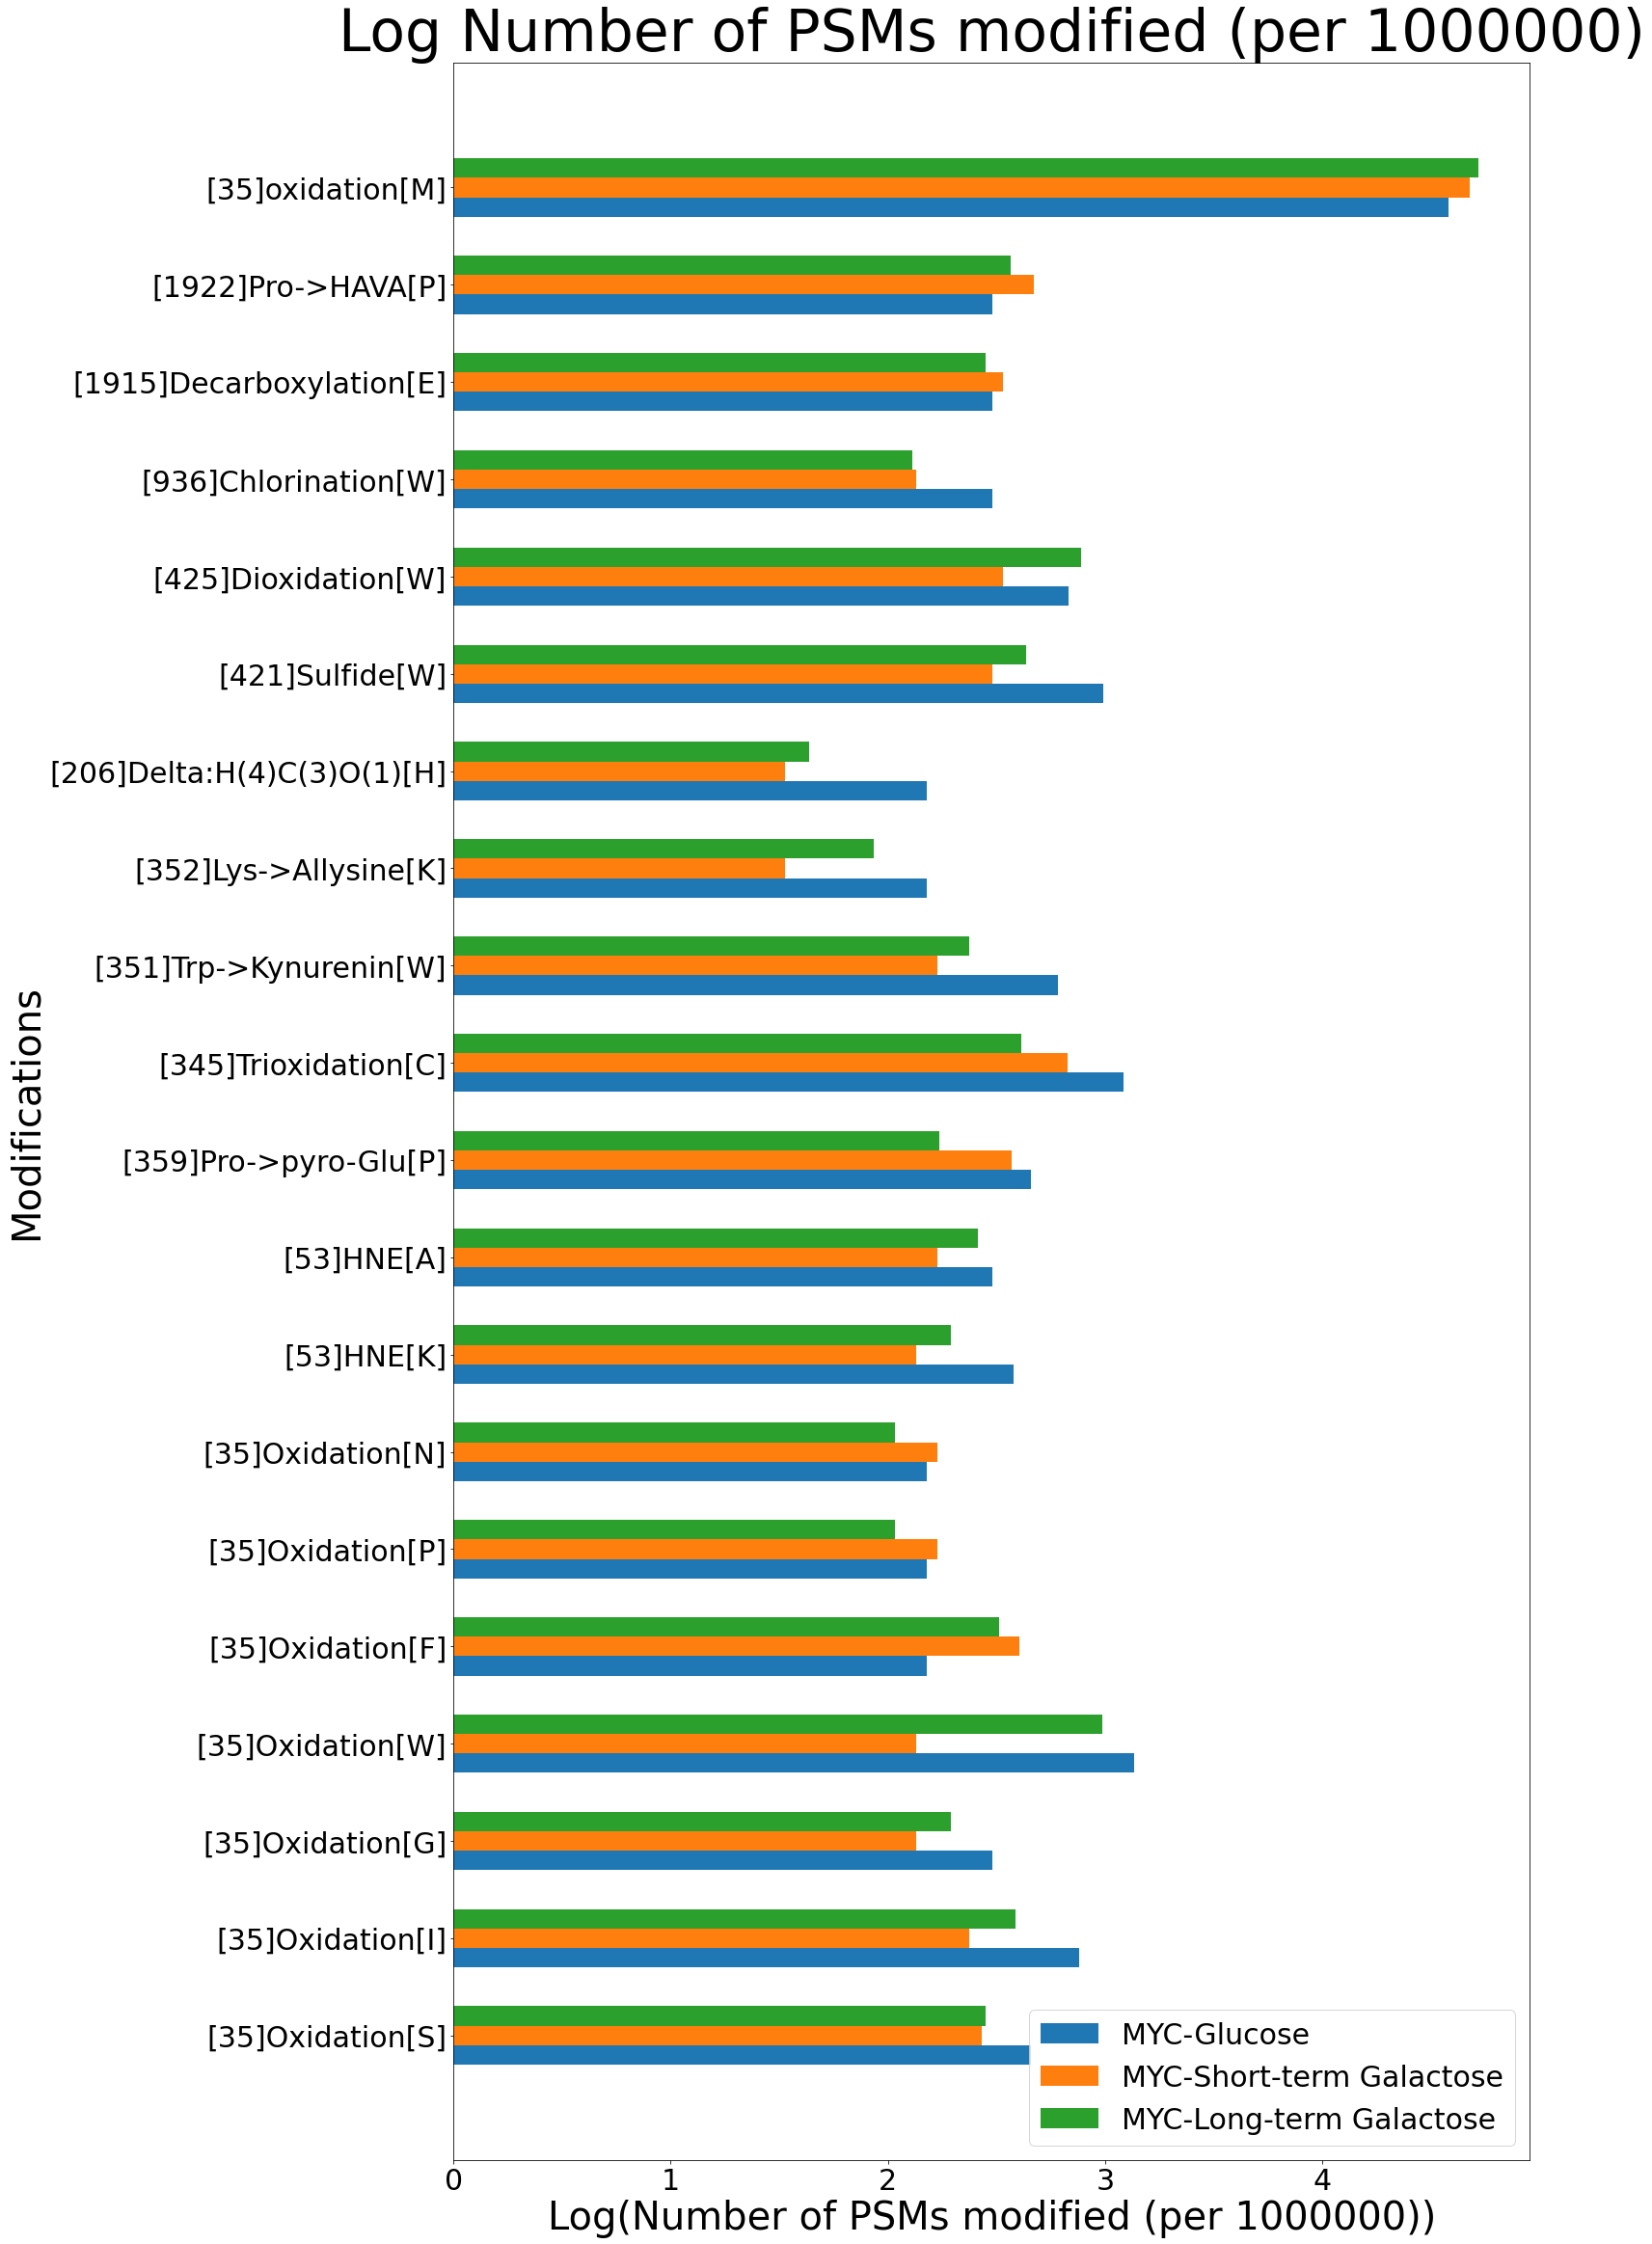

In [29]:
y = modr2["Modification"]
xGlu = np.log10(modr2['Ratios_Glu']*1000000)
xstGal = np.log10(modr2['Ratios_stGal']*1000000)
xltGal = np.log10(modr2['Ratios_ltGal']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'MYC-Glucose')
plt.barh(y_axis, xstGal, 0.2, label = 'MYC-Short-term Galactose')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'MYC-Long-term Galactose')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

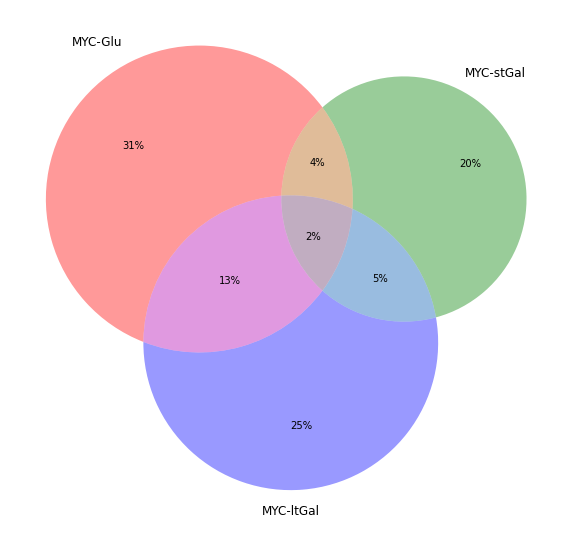

In [30]:
OA.condition_venn([MYCrep,MYCstrep,MYCltrep], ["MYC-Glu", "MYC-stGal", "MYC-ltGal"])

In [31]:
RPMMYC = OA.relative_PSM_modification(MYCrep)
RPMMYCst = OA.relative_PSM_modification(MYCstrep)
RPMMYClt = OA.relative_PSM_modification(MYCltrep)

In [32]:
RPM2 = pd.merge(RPMMYC,RPMMYCst, on="Amino acid", suffixes=('_MYC','_MYCst'))
RPM2 = pd.merge(RPM2, RPMMYClt, on="Amino acid")
RPM2 = RPM2.rename(columns={"Relative level of PSMs containing unmodified residue": "Relative level of PSMs containing unmodified residue_MYClt"})
RPM2

,Amino acid,Relative level of PSMs containing unmodified residue_MYC,Relative level of PSMs containing unmodified residue_MYCst,Relative level of PSMs containing unmodified residue_MYClt
0,A,0.998165,0.998167,0.998184
1,R,0.996336,0.999112,0.998238
2,N,0.989766,0.994616,0.990817
3,D,0.992454,0.992552,0.994335
4,C,0.041919,0.039667,0.040771
5,Q,0.984909,0.985945,0.987187
6,E,0.991502,0.994746,0.995139
7,G,0.999331,0.999708,0.999594
8,H,0.998912,0.997516,0.997616
9,I,0.999219,0.999604,0.999593


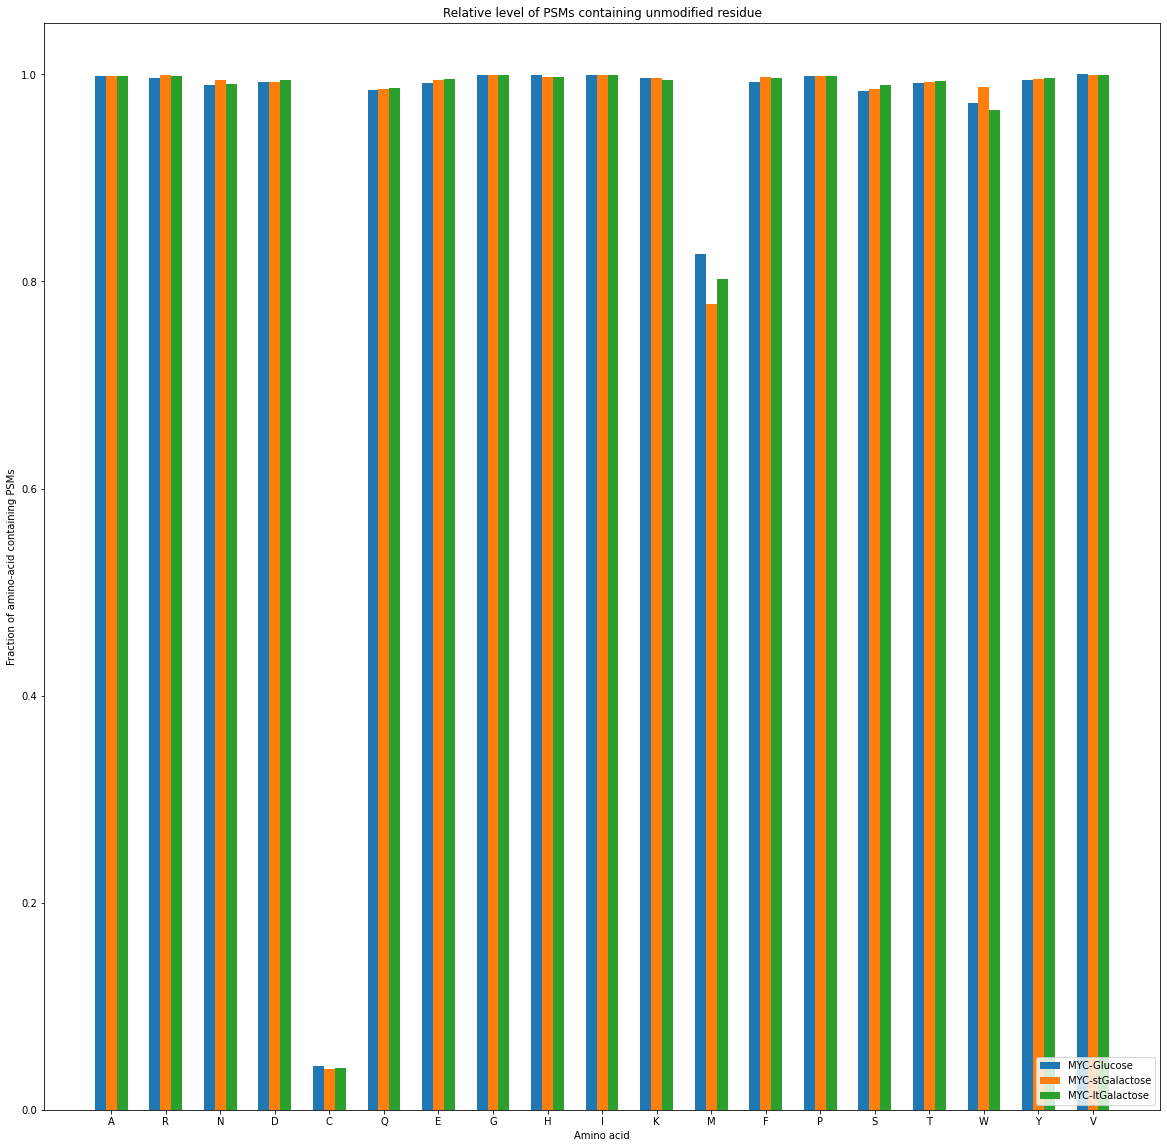

In [33]:
x = RPM2["Amino acid"]
xGlu = RPM2["Relative level of PSMs containing unmodified residue_MYC"]
xst = RPM2['Relative level of PSMs containing unmodified residue_MYCst']
xlt = RPM2['Relative level of PSMs containing unmodified residue_MYClt']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'MYC-Glucose')
plt.bar(x_axis, xst, 0.2, label = 'MYC-stGalactose')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'MYC-ltGalactose')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

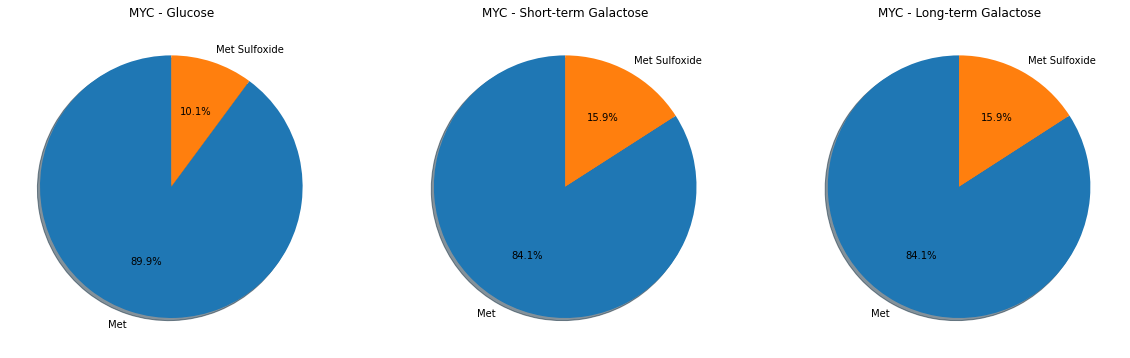

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(MYCrep, ax1)
OA.methionine_overview(MYCstrep, ax2)
OA.methionine_overview(MYCltrep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("MYC - Glucose")
ax2.set_title("MYC - Short-term Galactose")
ax3.set_title("MYC - Long-term Galactose")
plt.show()

### 3) None in Glucose, None in short-term Galactose, None in long-term Galactose

In [36]:
print("There are this many replicates of Control treatment: {}".format(Control["spectrum_file"].nunique()))
print("There are this many replicates of Controlst treatment: {}".format(Controlst["spectrum_file"].nunique()))
print("There are this many replicates of Controllt treatment: {}".format(Controllt["spectrum_file"].nunique()))

There are this many replicates of Control treatment: 4
There are this many replicates of Controlst treatment: 4
There are this many replicates of Controllt treatment: 4


In [37]:
Controlrep = OA.replicate_filter(Control,2)
Controlstrep = OA.replicate_filter(Controlst,2)
Controlltrep = OA.replicate_filter(Controllt,2)

In [38]:
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Controlst treatment subset: {}".format((Controlstrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Controllt treatment subset: {}".format((Controlltrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 4.483668086833029 %
The ratio of PSMs that contain an oxidative modification in the Controlst treatment subset: 4.0897315769167175 %
The ratio of PSMs that contain an oxidative modification in the Controllt treatment subset: 5.427662361968931 %


In [39]:
mrControlrep = OA.modratios(Controlrep)
mrControlstrep = OA.modratios(Controlst)
mrControlltrep = OA.modratios(Controllt)

In [41]:
modr_temp3 = pd.merge(mrControlltrep, mrControlstrep, on="Modification", suffixes=('_ltGal', '_stGal'))
modr3 = pd.merge(modr_temp3, mrControlrep, on="Modification")
modr3 = modr3.rename(columns={'Ratios':'Ratios_Glu'})
modr3 = modr3.drop(modr3[(modr3["Ratios_ltGal"] == 0) | (modr3["Ratios_stGal"] == 0) | (modr3["Ratios_Glu"] == 0)].index)
modr3

,Modification,Ratios_ltGal,Ratios_stGal,Ratios_Glu
1,[35]Oxidation[E],0.000209,0.000324,0.000171
5,[35]Oxidation[I],0.000358,0.000344,0.000343
8,[35]Oxidation[W],0.002175,0.000466,0.001028
20,[53]HNE[K],0.000209,0.000203,0.000171
23,[53]HNE[A],0.000478,0.000304,0.000685
25,[359]Pro->pyro-Glu[P],0.000269,0.000243,0.000171
28,[350]Trp->Hydroxykynurenin[W],0.000030,0.000020,0.000086
32,[345]Trioxidation[W],0.000090,0.000081,0.000257
33,[345]Trioxidation[C],0.001074,0.000324,0.001284
35,[354]Nitro[Y],0.000060,0.000081,0.000171


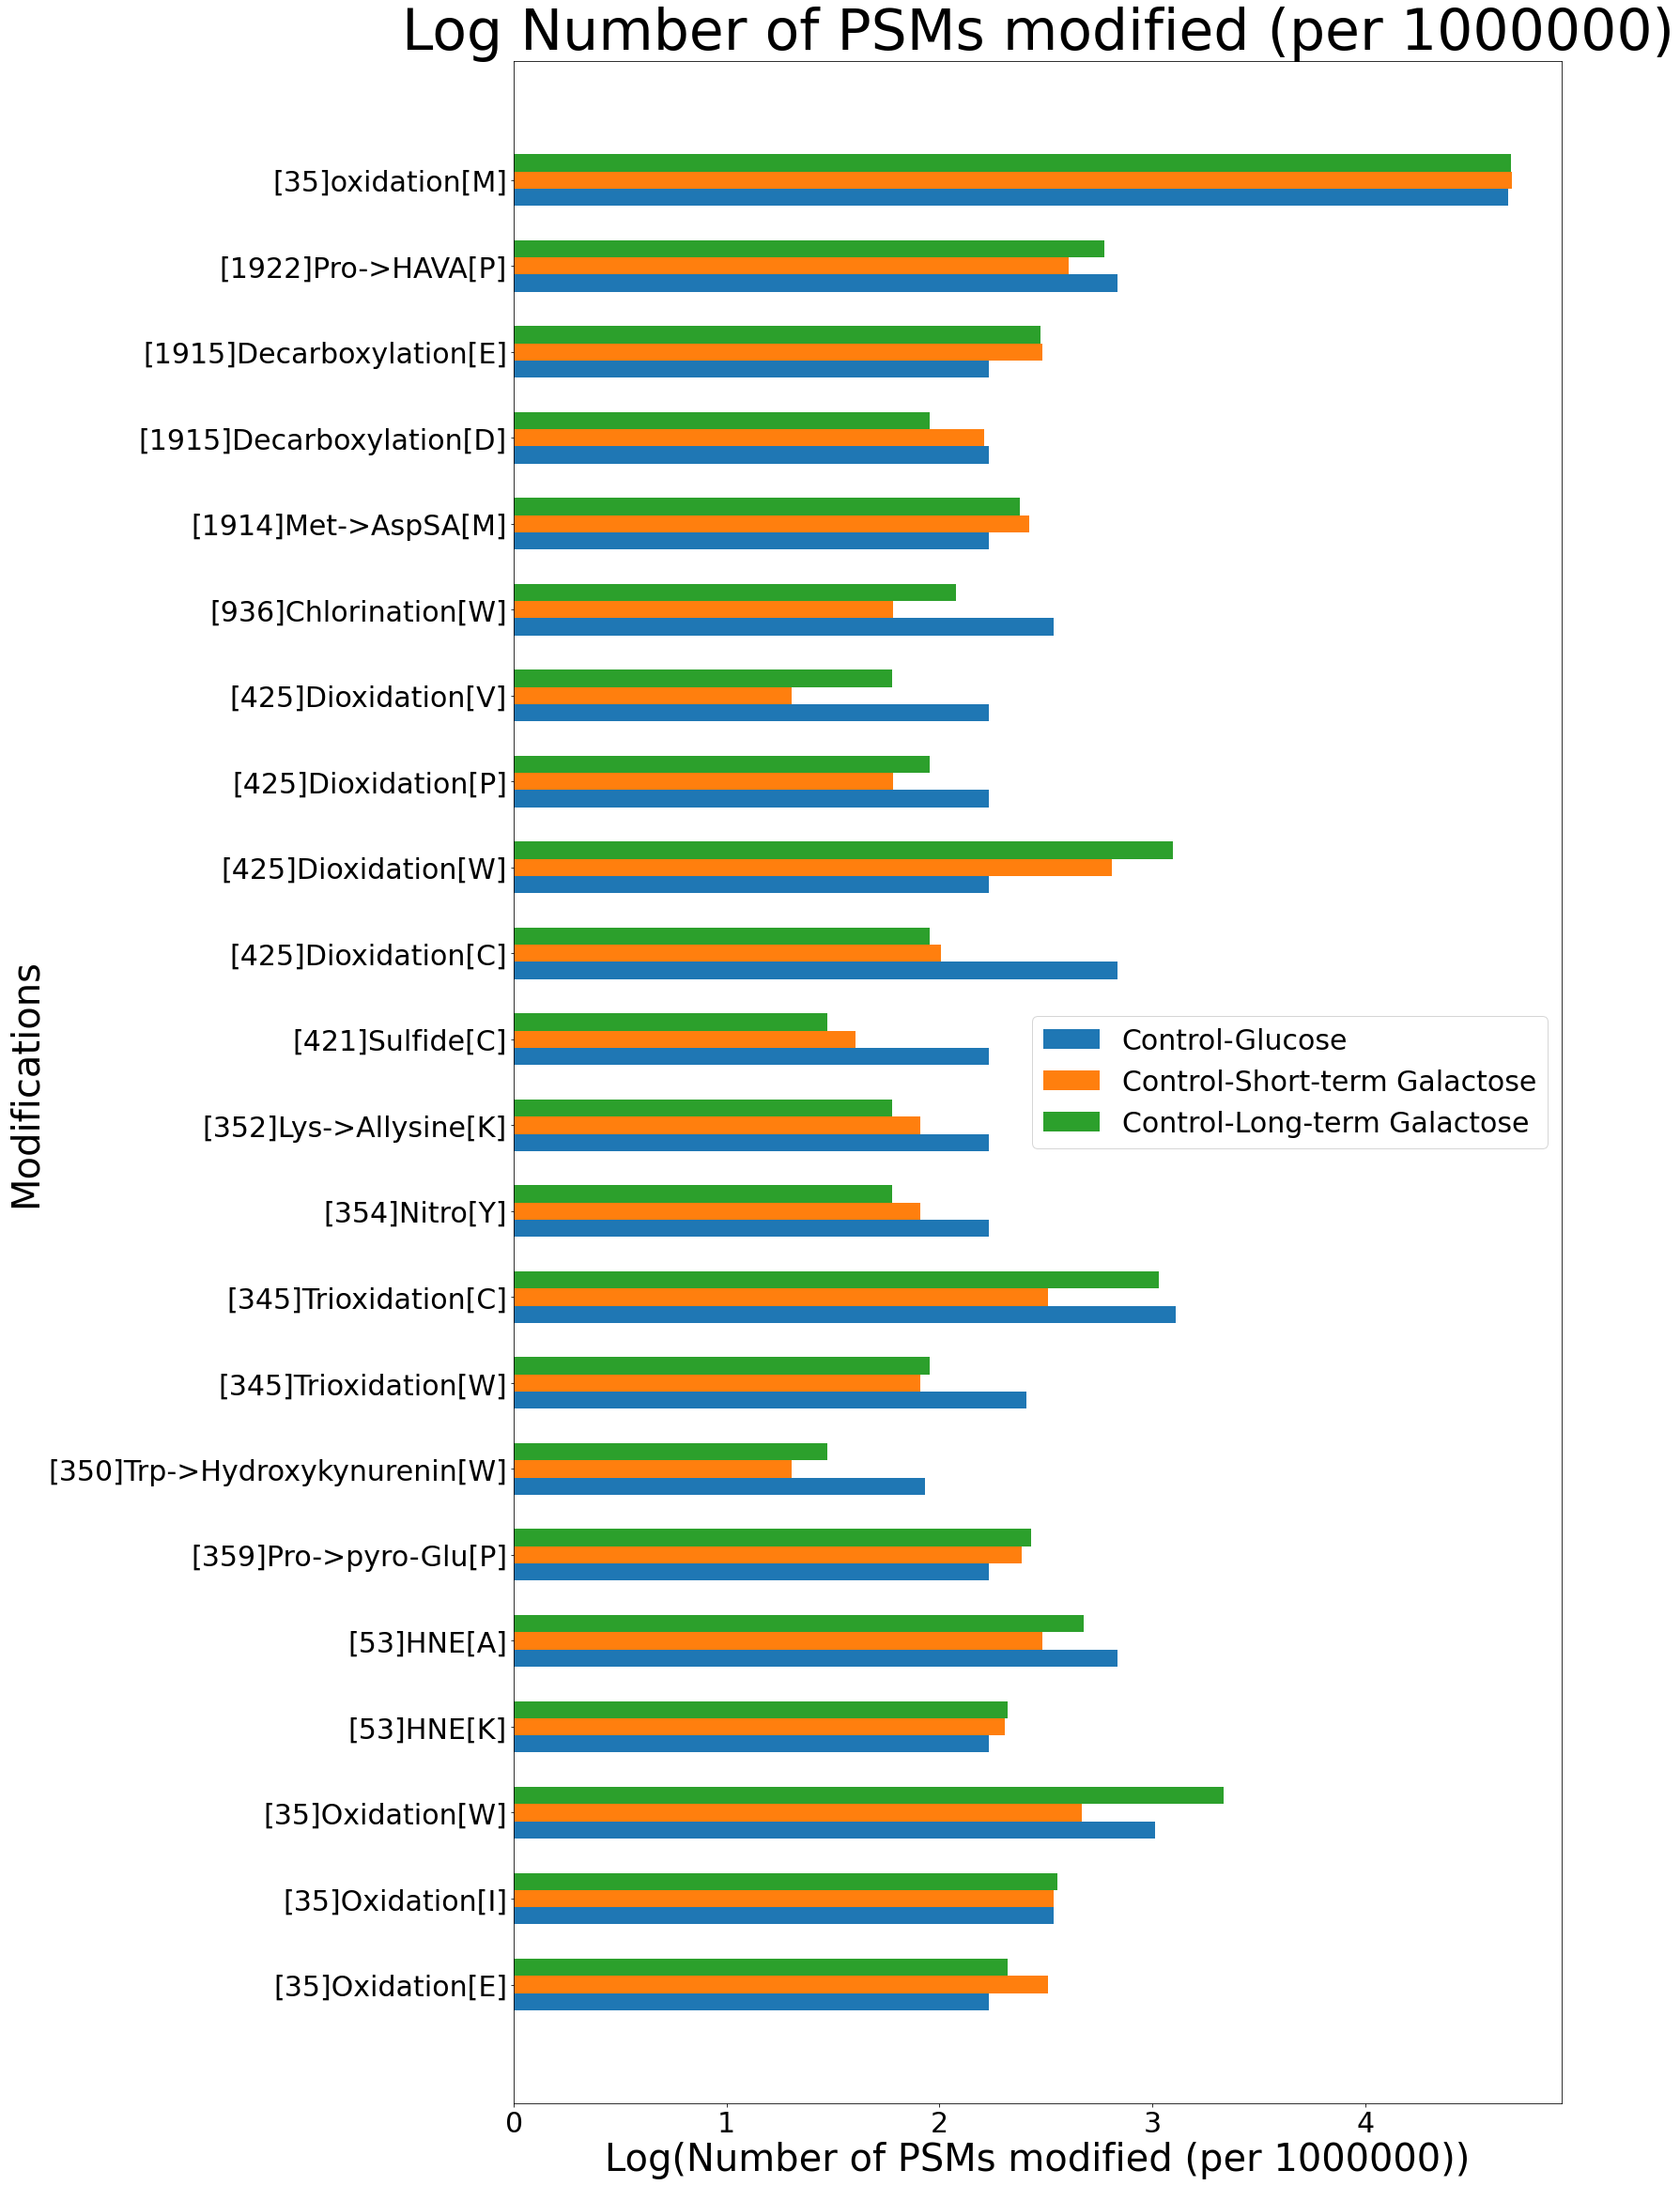

In [43]:
y = modr3["Modification"]
xGlu = np.log10(modr3['Ratios_Glu']*1000000)
xstGal = np.log10(modr3['Ratios_stGal']*1000000)
xltGal = np.log10(modr3['Ratios_ltGal']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'Control-Glucose')
plt.barh(y_axis, xstGal, 0.2, label = 'Control-Short-term Galactose')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'Control-Long-term Galactose')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

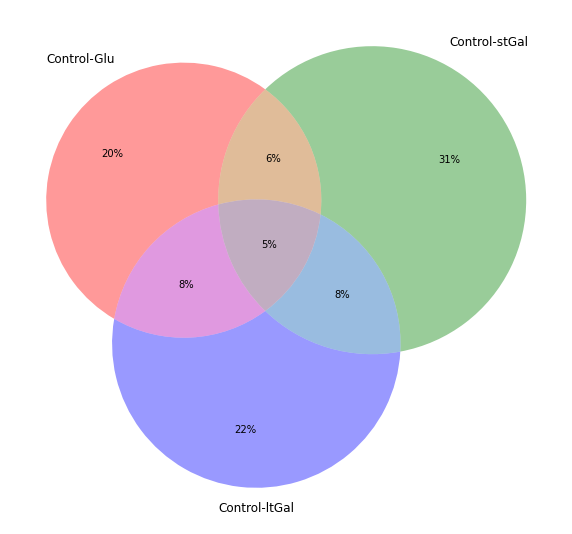

In [45]:
OA.condition_venn([Controlrep,Controlstrep,Controlltrep], ["Control-Glu", "Control-stGal", "Control-ltGal"])

In [46]:
RPMControl = OA.relative_PSM_modification(Controlrep)
RPMControlst = OA.relative_PSM_modification(Controlstrep)
RPMControllt = OA.relative_PSM_modification(Controlltrep)

In [50]:
RPM3 = pd.merge(RPMControl,RPMControlst, on="Amino acid", suffixes=('_Control','_Controlst'))
RPM3 = pd.merge(RPM3, RPMControllt, on="Amino acid")
RPM3 = RPM3.rename(columns={"Relative level of PSMs containing unmodified residue": "Relative level of PSMs containing unmodified residue_Controllt"})
RPM3

,Amino acid,Relative level of PSMs containing unmodified residue_Control,Relative level of PSMs containing unmodified residue_Controlst,Relative level of PSMs containing unmodified residue_Controllt
0,A,0.998433,0.998892,0.998026
1,R,0.997391,0.997743,0.998254
2,N,0.990915,0.993164,0.993548
3,D,0.993651,0.995530,0.994002
4,C,0.125770,0.048179,0.054888
5,Q,0.986634,0.990191,0.992717
6,E,0.996511,0.994557,0.995719
7,G,1.000000,0.999279,0.999781
8,H,0.996069,0.998159,0.998007
9,I,0.999700,0.999636,0.999719


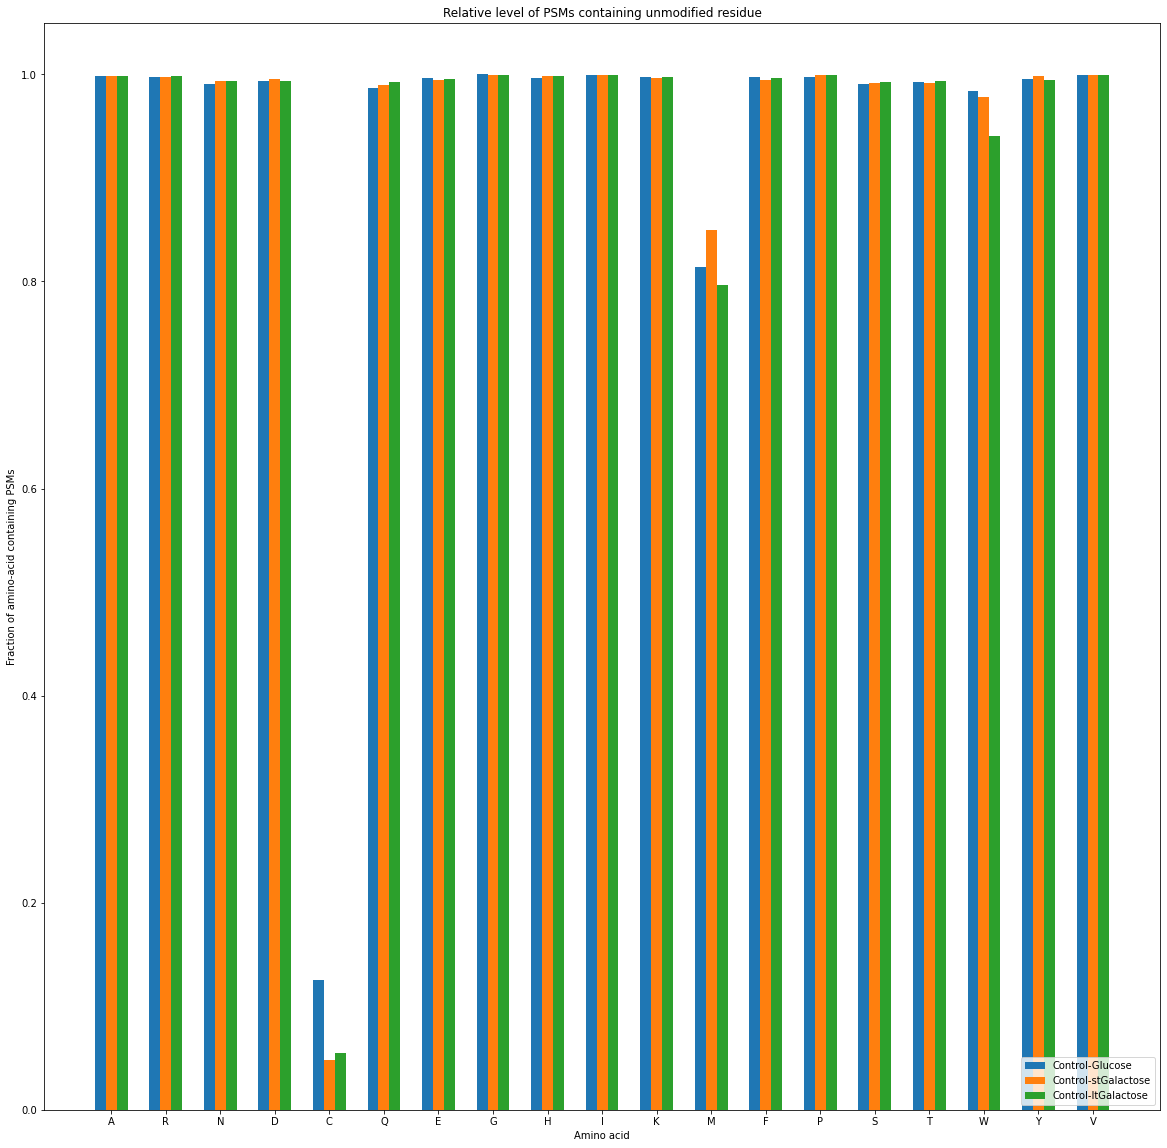

In [51]:
x = RPM3["Amino acid"]
xGlu = RPM3["Relative level of PSMs containing unmodified residue_Control"]
xst = RPM3['Relative level of PSMs containing unmodified residue_Controlst']
xlt = RPM3['Relative level of PSMs containing unmodified residue_Controllt']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Control-Glucose')
plt.bar(x_axis, xst, 0.2, label = 'Control-stGalactose')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'Control-ltGalactose')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

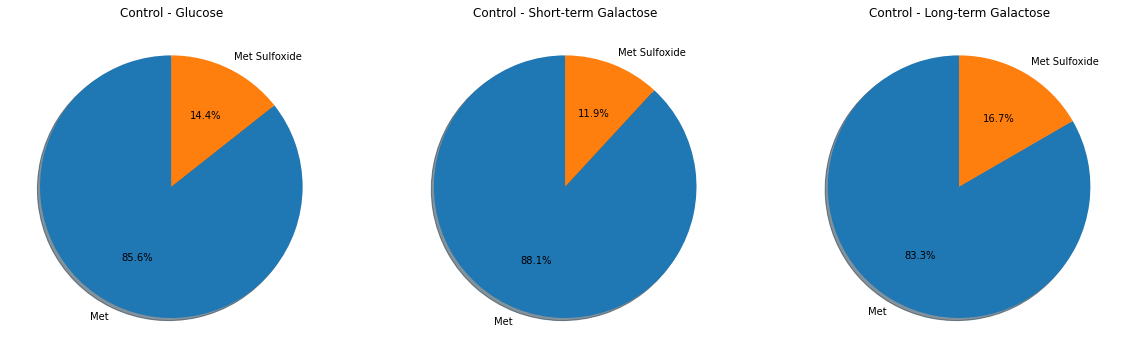

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Controlrep, ax1)
OA.methionine_overview(Controlstrep, ax2)
OA.methionine_overview(Controlltrep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Control - Glucose")
ax2.set_title("Control - Short-term Galactose")
ax3.set_title("Control - Long-term Galactose")
plt.show()

### 4) Control vs Constitutively active AKT vs Constitutively active MYC in Glucose medium

In [54]:
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: {}".format((AKTrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: {}".format((MYCrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 4.483668086833029 %
The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: 3.919445647466436 %
The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: 3.823149994136273 %


In [60]:
modr_temp4 = pd.merge(mrAKTrep, mrMYCrep, on="Modification", suffixes=('_AKT', '_MYC'))
modr4 = pd.merge(modr_temp4, mrControlrep, on="Modification")
modr4 = modr4.rename(columns={'Ratios' : 'Ratios_Control'})
modr4 = modr4.drop(modr4[(modr4['Ratios_MYC'] == 0) | (modr4['Ratios_AKT'] == 0) | (modr4['Ratios_Control'] == 0)].index)
modr4

,Modification,Ratios_AKT,Ratios_MYC,Ratios_Control
8,[35]Oxidation[W],0.001611,0.001362,0.001028
23,[53]HNE[A],0.000269,0.000303,0.000685
33,[345]Trioxidation[C],0.000672,0.001211,0.001284
76,[425]Dioxidation[C],0.000269,0.000303,0.000685
77,[425]Dioxidation[W],0.001209,0.000681,0.000171
110,[1915]Decarboxylation[E],0.000538,0.000303,0.000171
129,[35]oxidation[M],0.038775,0.038254,0.046907


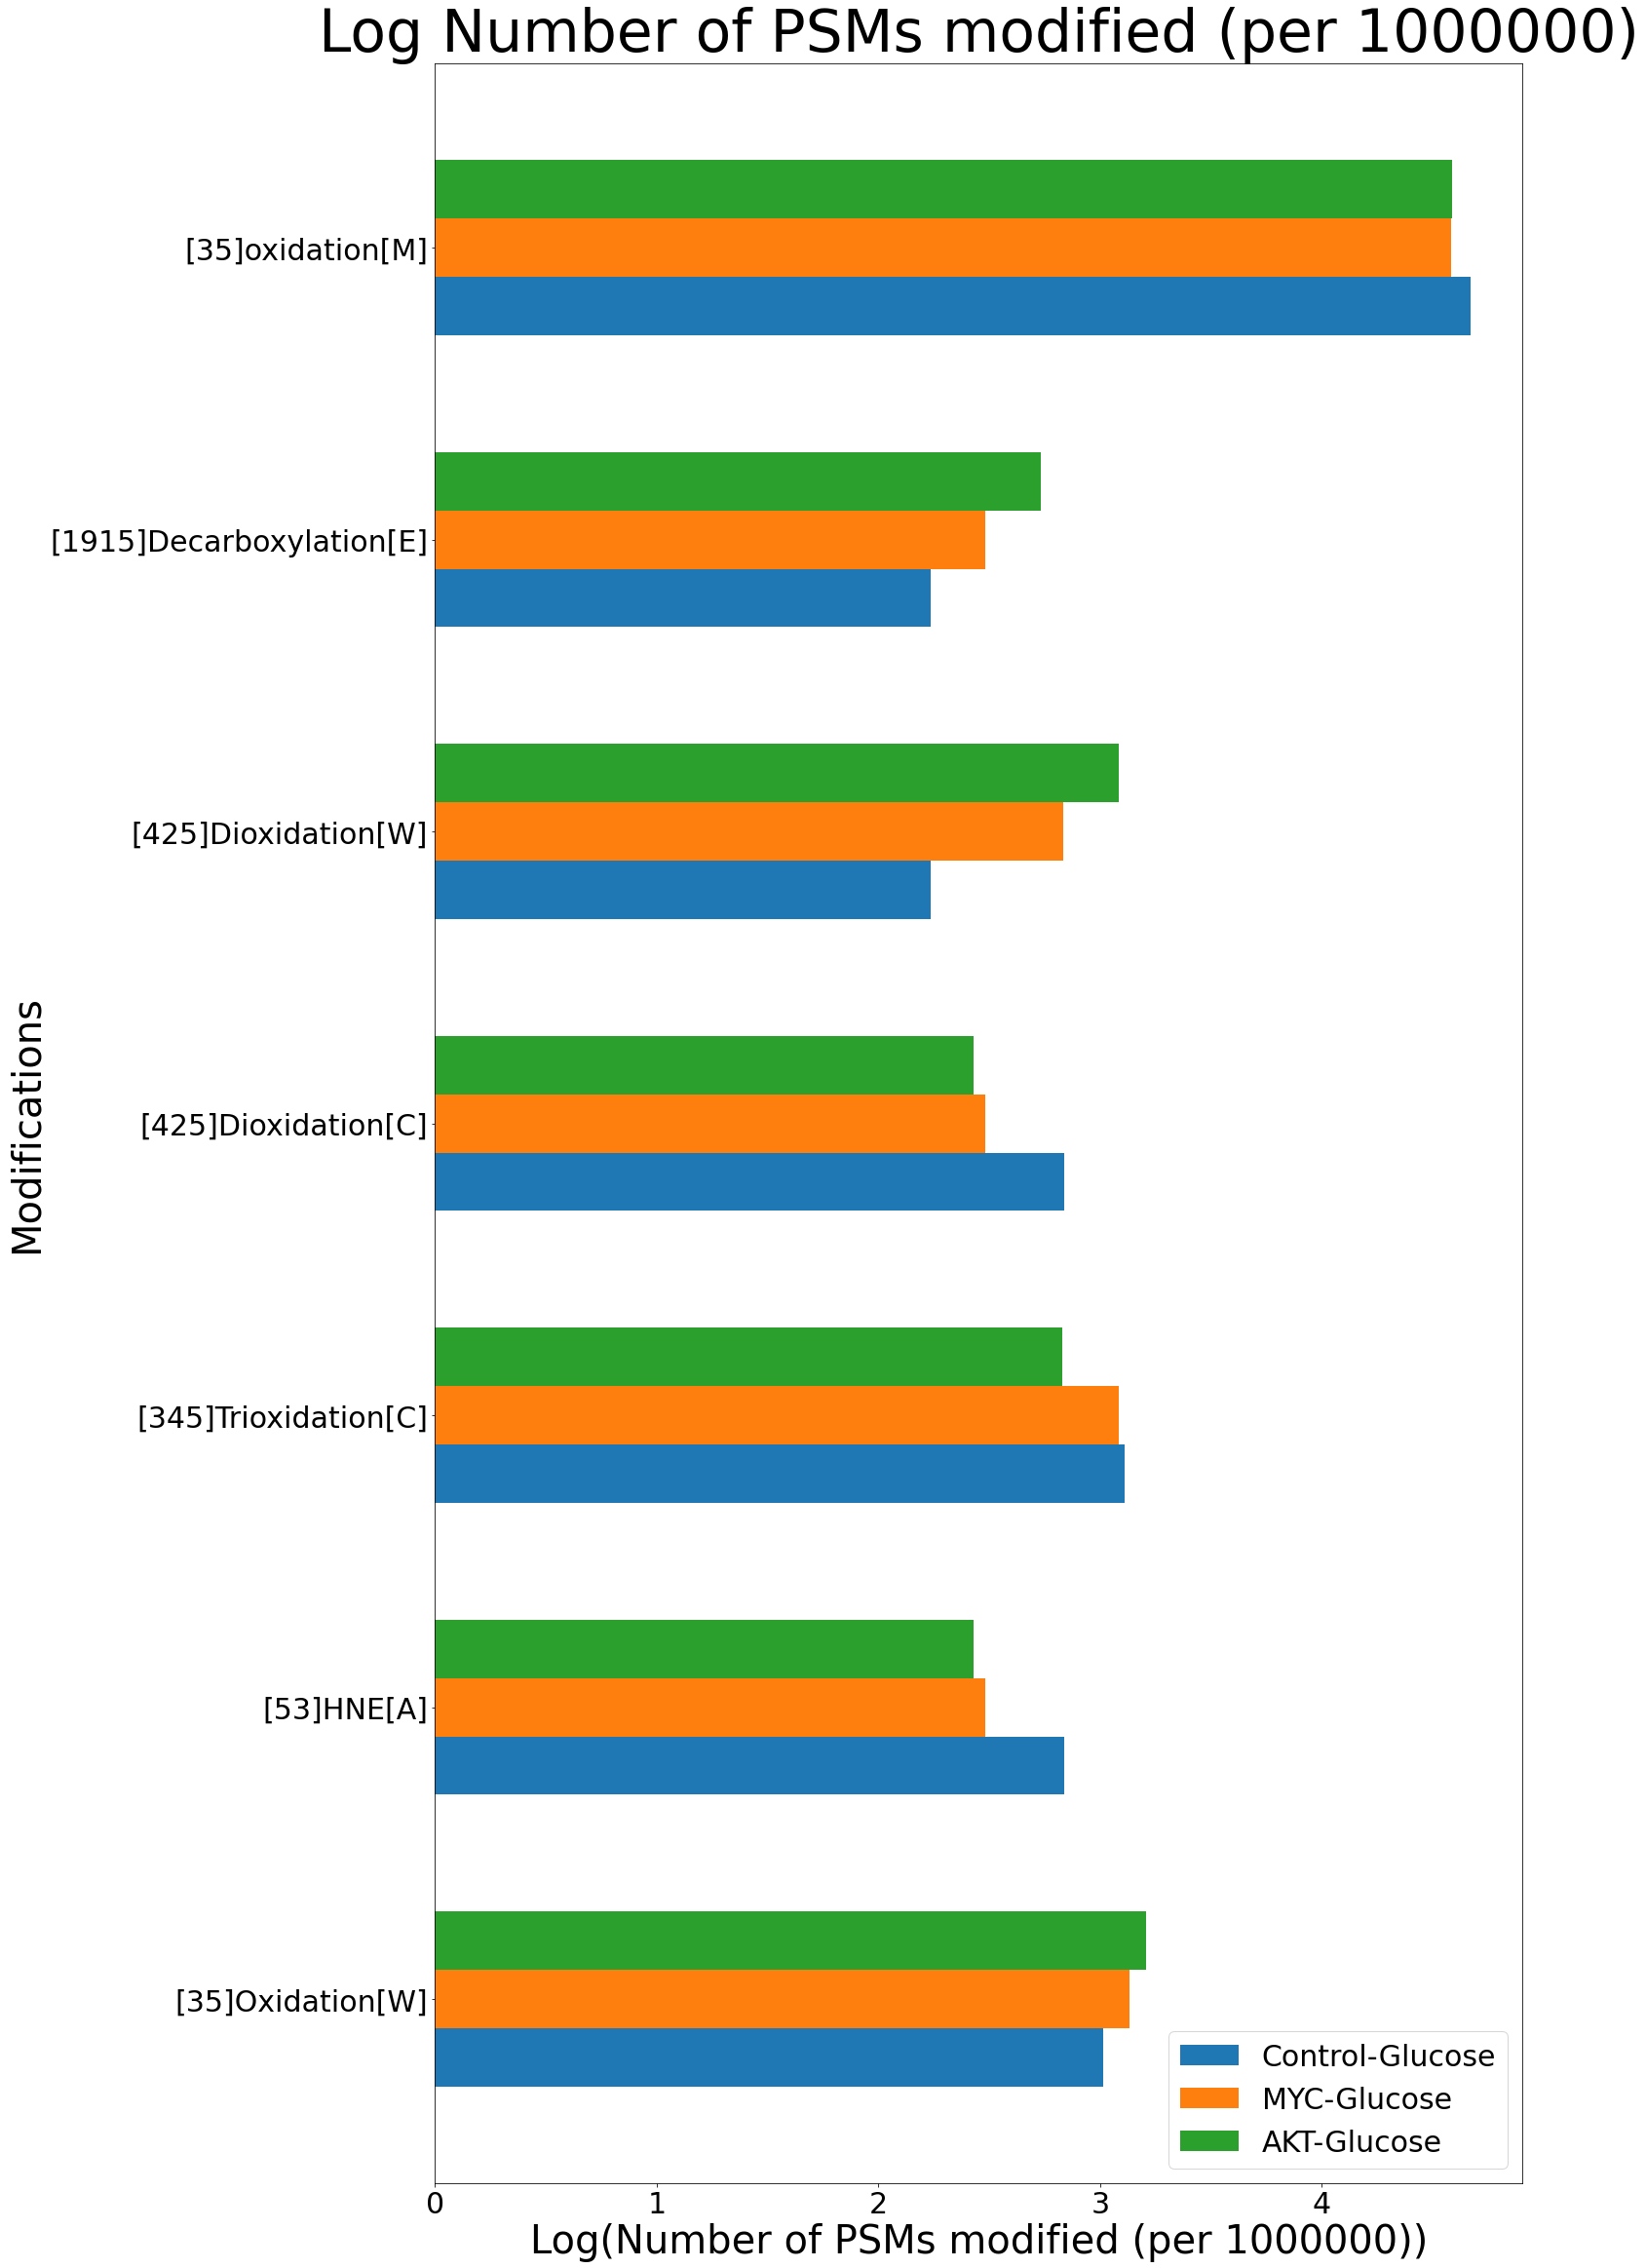

In [61]:
y = modr4["Modification"]
xGlu = np.log10(modr4['Ratios_Control']*1000000)
xstGal = np.log10(modr4['Ratios_MYC']*1000000)
xltGal = np.log10(modr4['Ratios_AKT']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'Control-Glucose')
plt.barh(y_axis, xstGal, 0.2, label = 'MYC-Glucose')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'AKT-Glucose')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

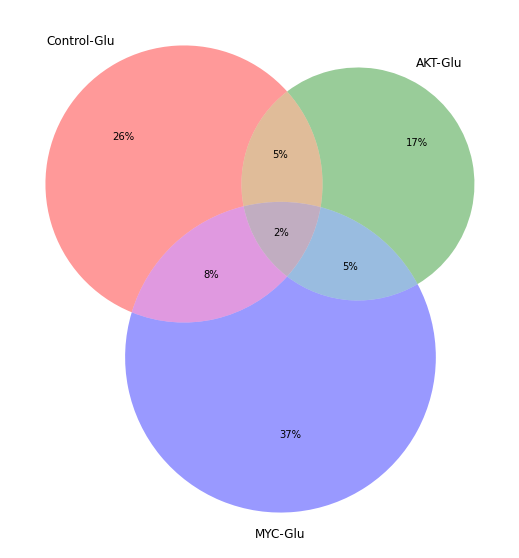

In [62]:
OA.condition_venn([Controlrep,AKTrep,MYCrep], ["Control-Glu", "AKT-Glu", "MYC-Glu"])

In [66]:
RPM4 = pd.merge(RPMControl,RPMAKT, on="Amino acid", suffixes=('_Control','_AKT'))
RPM4 = pd.merge(RPM4, RPMMYC, on="Amino acid")
RPM4 = RPM.rename(columns={"Relative level of PSMs containing unmodified residue": "Relative level of PSMs containing unmodified residue_MYC"})
RPM4

,Amino acid,Relative level of PSMs containing unmodified residue_Control,Relative level of PSMs containing unmodified residue_AKT,Relative level of PSMs containing unmodified residue_MYC
0,A,0.998433,0.998316,0.998165
1,R,0.997391,0.996830,0.996336
2,N,0.990915,0.989226,0.989766
3,D,0.993651,0.992172,0.992454
4,C,0.125770,0.025022,0.041919
5,Q,0.986634,0.990845,0.984909
6,E,0.996511,0.994979,0.991502
7,G,1.000000,0.998888,0.999331
8,H,0.996069,0.997434,0.998912
9,I,0.999700,0.999500,0.999219


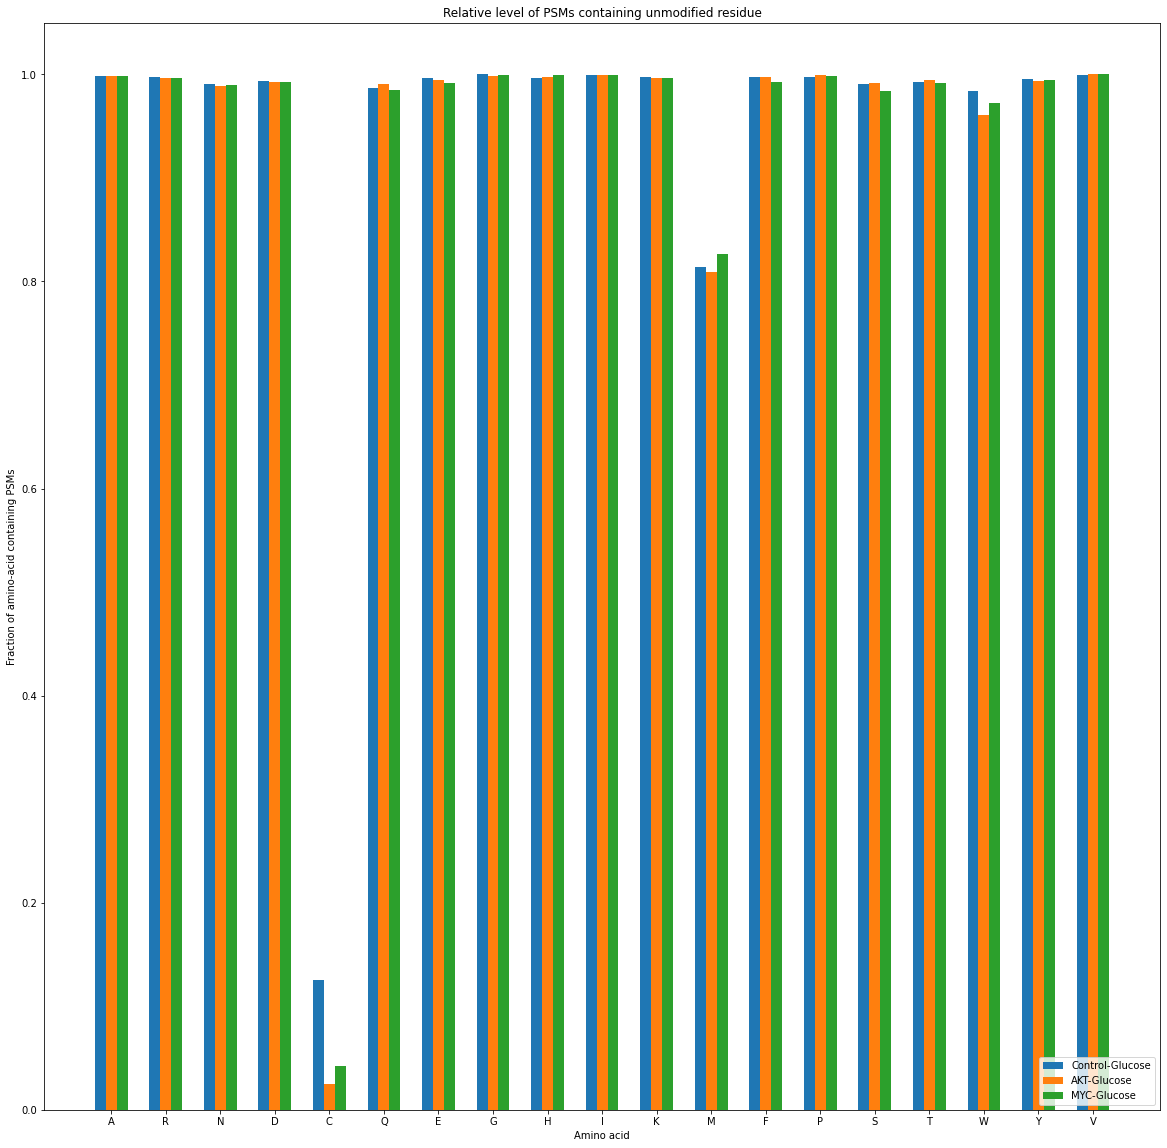

In [67]:
x = RPM4["Amino acid"]
xGlu = RPM4["Relative level of PSMs containing unmodified residue_Control"]
xst = RPM4['Relative level of PSMs containing unmodified residue_AKT']
xlt = RPM4['Relative level of PSMs containing unmodified residue_MYC']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Control-Glucose')
plt.bar(x_axis, xst, 0.2, label = 'AKT-Glucose')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'MYC-Glucose')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

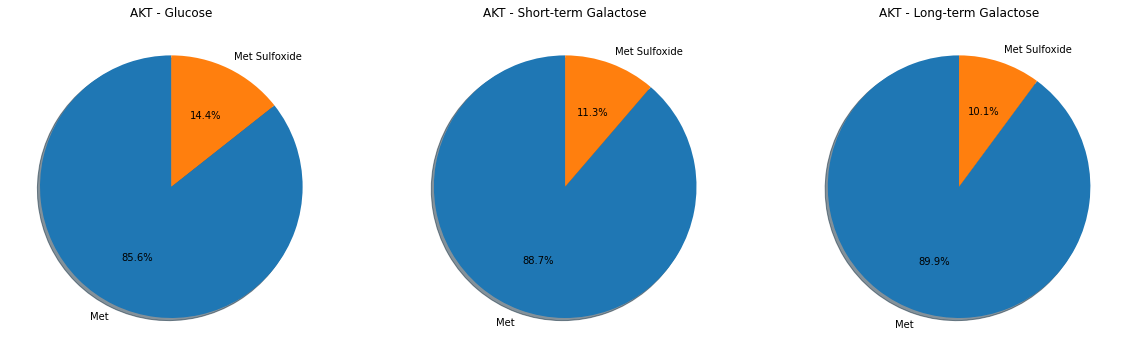

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Controlrep, ax1)
OA.methionine_overview(AKTrep, ax2)
OA.methionine_overview(MYCrep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Control - Glucose")
ax2.set_title("AKT - Glucose")
ax3.set_title("MYC - Glucose")
plt.show()

### 5) Control, AKT and MYC in short-term Galactose

In [69]:
print("The ratio of PSMs that contain an oxidative modification in the Controlst treatment subset: {}".format((Controlstrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the AKTst treatment subset: {}".format((AKTstrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the MYCst treatment subset: {}".format((MYCstrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 4.0897315769167175 %
The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: 5.028423533761612 %
The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: 4.525823285945655 %


In [70]:
modr_temp5 = pd.merge(mrAKTstrep, mrMYCstrep, on="Modification", suffixes=('_AKT', '_MYC'))
modr5 = pd.merge(modr_temp5, mrControlstrep, on="Modification")
modr5 = modr5.rename(columns={'Ratios' : 'Ratios_Control'})
modr5 = modr5.drop(modr5[(modr5['Ratios_MYC'] == 0) | (modr5['Ratios_AKT'] == 0) | (modr5['Ratios_Control'] == 0)].index)
modr5

,Modification,Ratios_AKT,Ratios_MYC,Ratios_Control
0,[35]Oxidation[T],0.000323,0.000169,0.000203
1,[35]Oxidation[E],0.000283,0.000202,0.000324
2,[35]Oxidation[S],0.000283,0.000270,0.000243
5,[35]Oxidation[I],0.000364,0.000236,0.000344
7,[35]Oxidation[G],0.000485,0.000135,0.000304
8,[35]Oxidation[W],0.000828,0.000135,0.000466
10,[35]Oxidation[H],0.000101,0.000034,0.000101
11,[35]Oxidation[V],0.000081,0.000169,0.000162
12,[35]Oxidation[R],0.000040,0.000034,0.000041
15,[35]Oxidation[F],0.000182,0.000405,0.000263


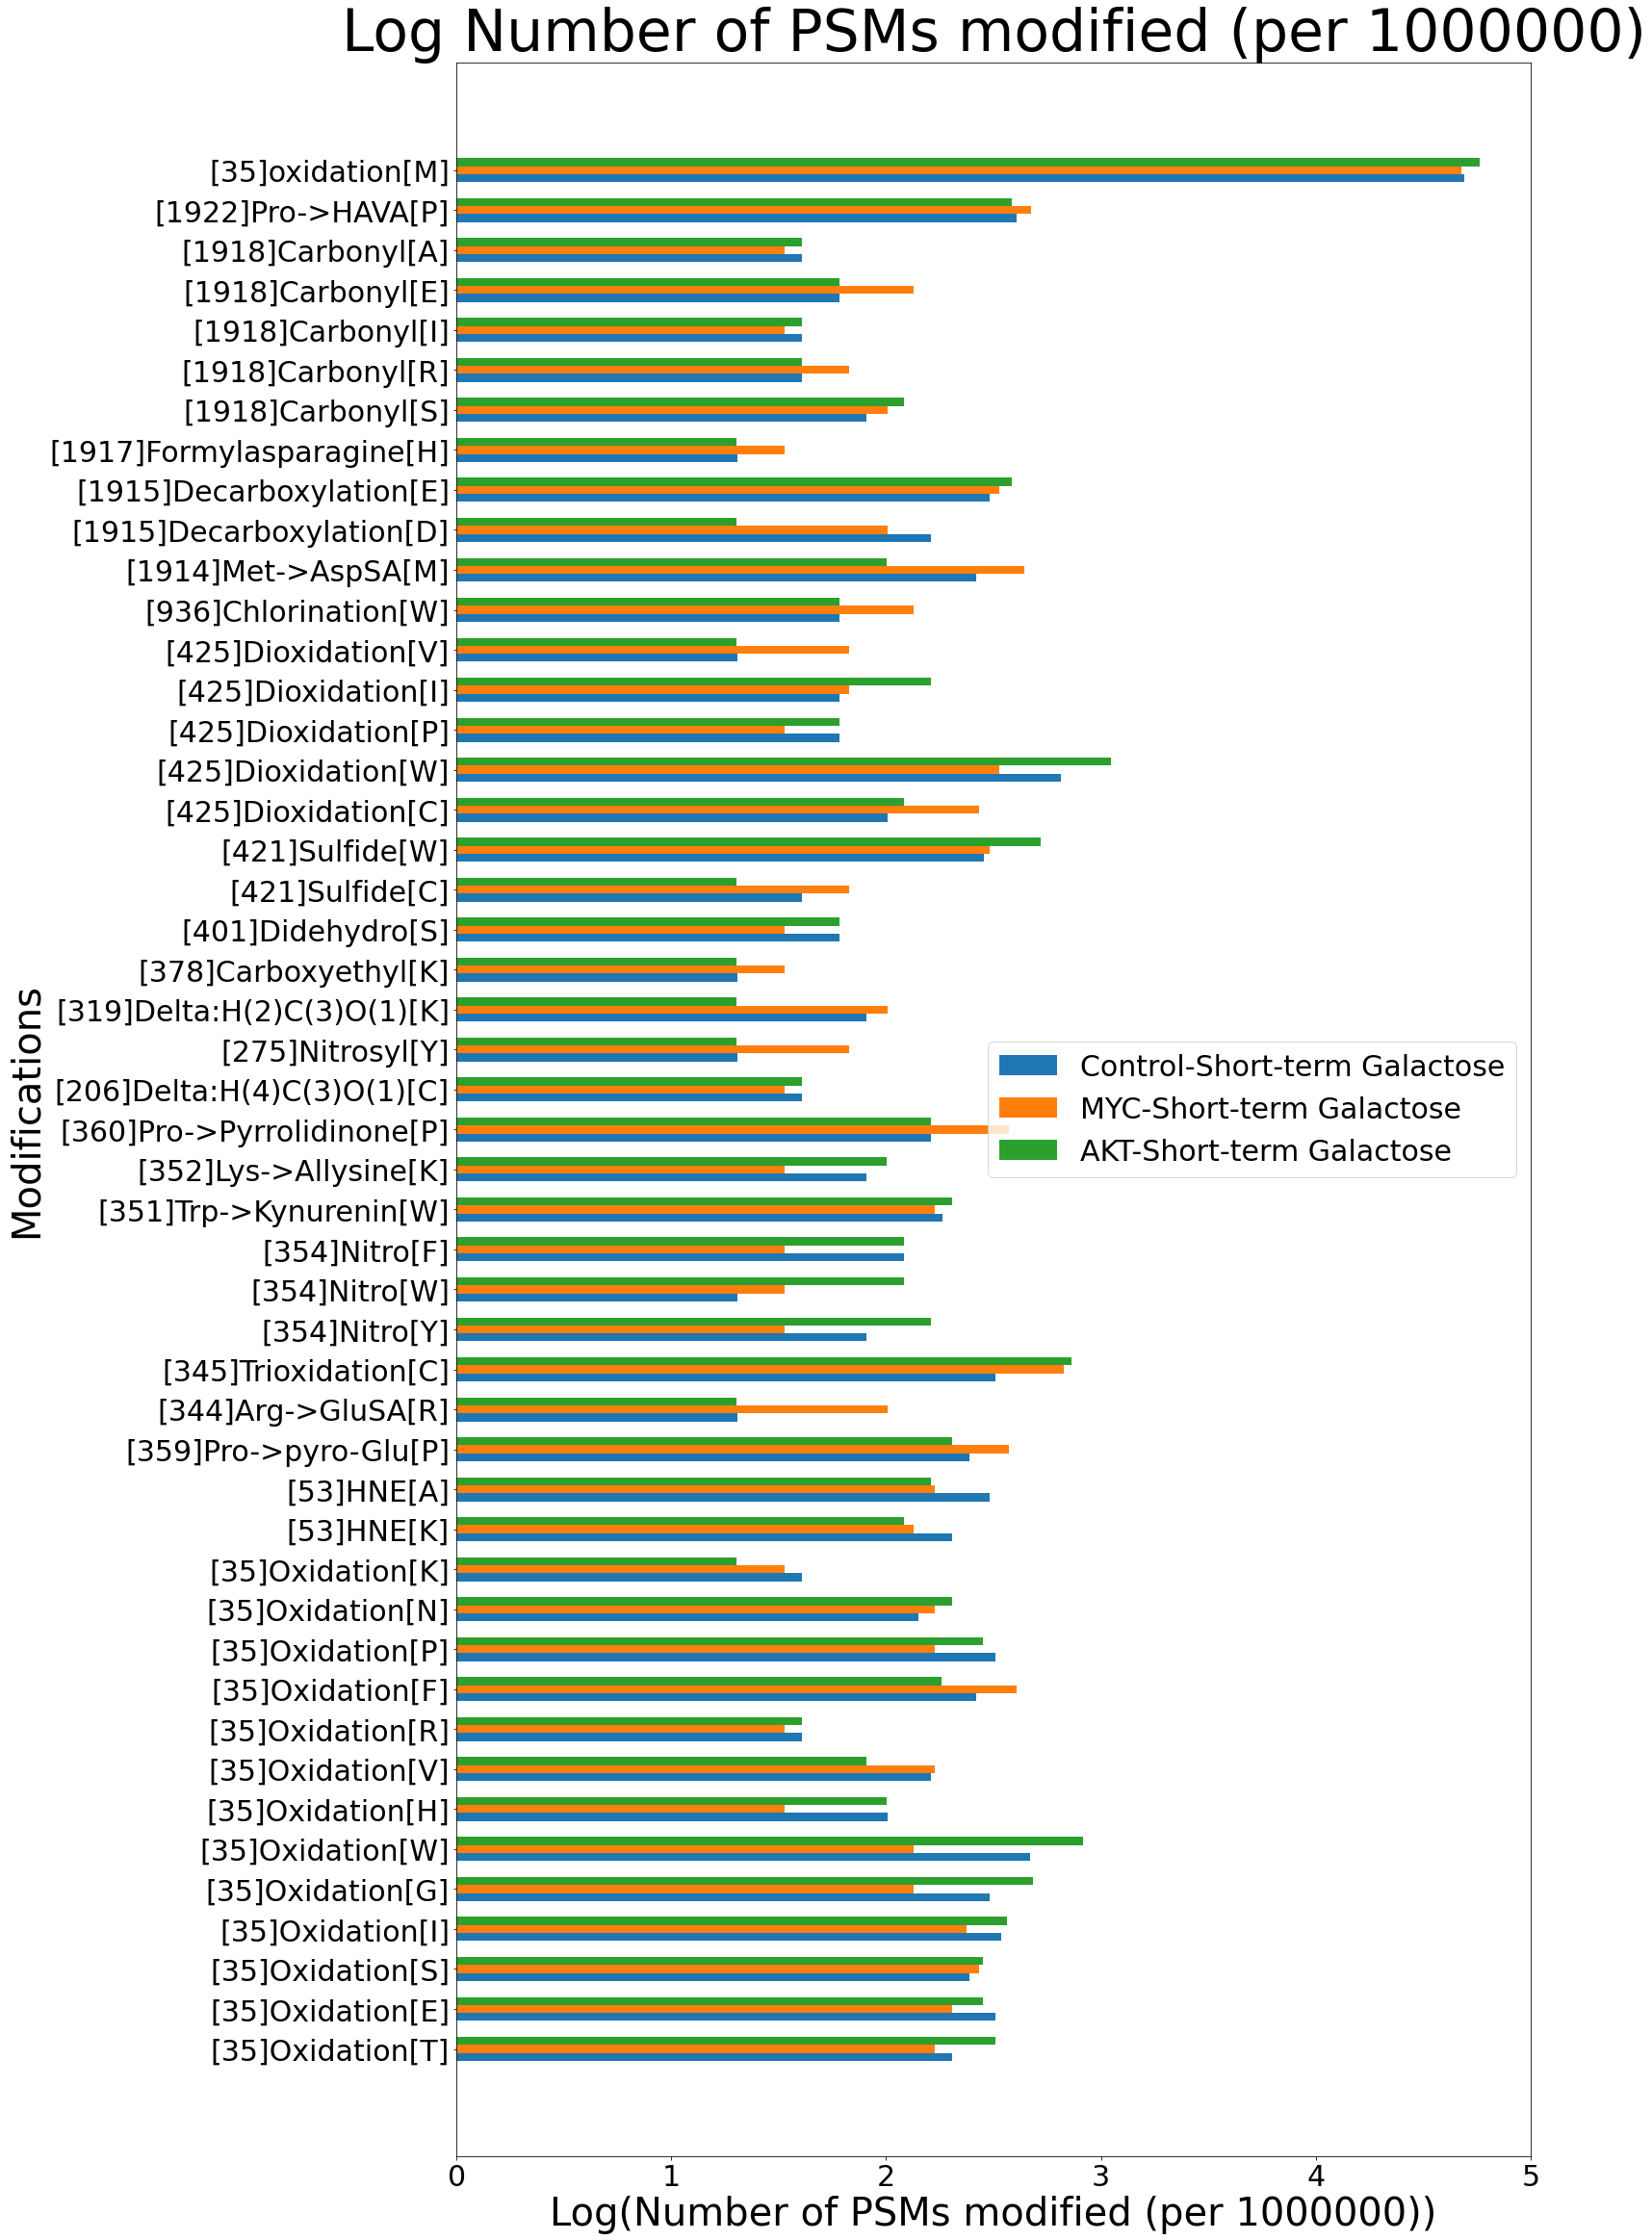

In [72]:
y = modr5["Modification"]
xGlu = np.log10(modr5['Ratios_Control']*1000000)
xstGal = np.log10(modr5['Ratios_MYC']*1000000)
xltGal = np.log10(modr5['Ratios_AKT']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'Control-Short-term Galactose')
plt.barh(y_axis, xstGal, 0.2, label = 'MYC-Short-term Galactose')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'AKT-Short-term Galactose')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

Orange more prevalent?

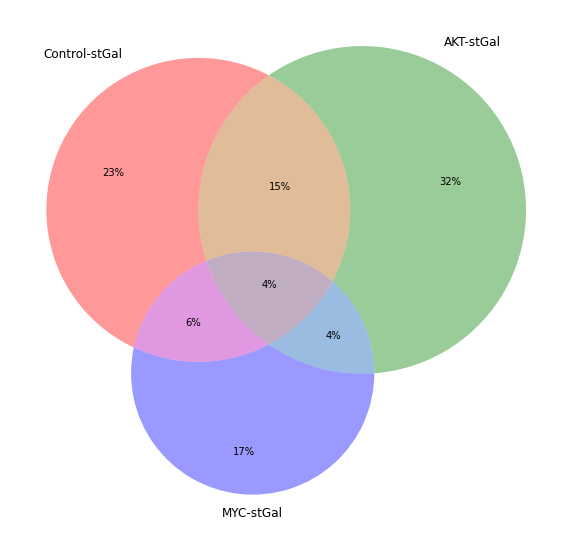

In [74]:
OA.condition_venn([Controlstrep,AKTstrep,MYCstrep], ["Control-stGal", "AKT-stGal", "MYC-stGal"])

In [75]:
RPM5 = pd.merge(RPMControlst,RPMAKTst, on="Amino acid", suffixes=('_Control','_AKT'))
RPM5 = pd.merge(RPM5, RPMMYCst, on="Amino acid")
RPM5 = RPM5.rename(columns={"Relative level of PSMs containing unmodified residue": "Relative level of PSMs containing unmodified residue_MYC"})
RPM5

,Amino acid,Relative level of PSMs containing unmodified residue_Control,Relative level of PSMs containing unmodified residue_AKT,Relative level of PSMs containing unmodified residue_MYC
0,A,0.998892,0.999305,0.998167
1,R,0.997743,0.998623,0.999112
2,N,0.993164,0.992295,0.994616
3,D,0.995530,0.993125,0.992552
4,C,0.048179,0.032637,0.039667
5,Q,0.990191,0.991742,0.985945
6,E,0.994557,0.993308,0.994746
7,G,0.999279,0.999550,0.999708
8,H,0.998159,0.996583,0.997516
9,I,0.999636,0.999395,0.999604


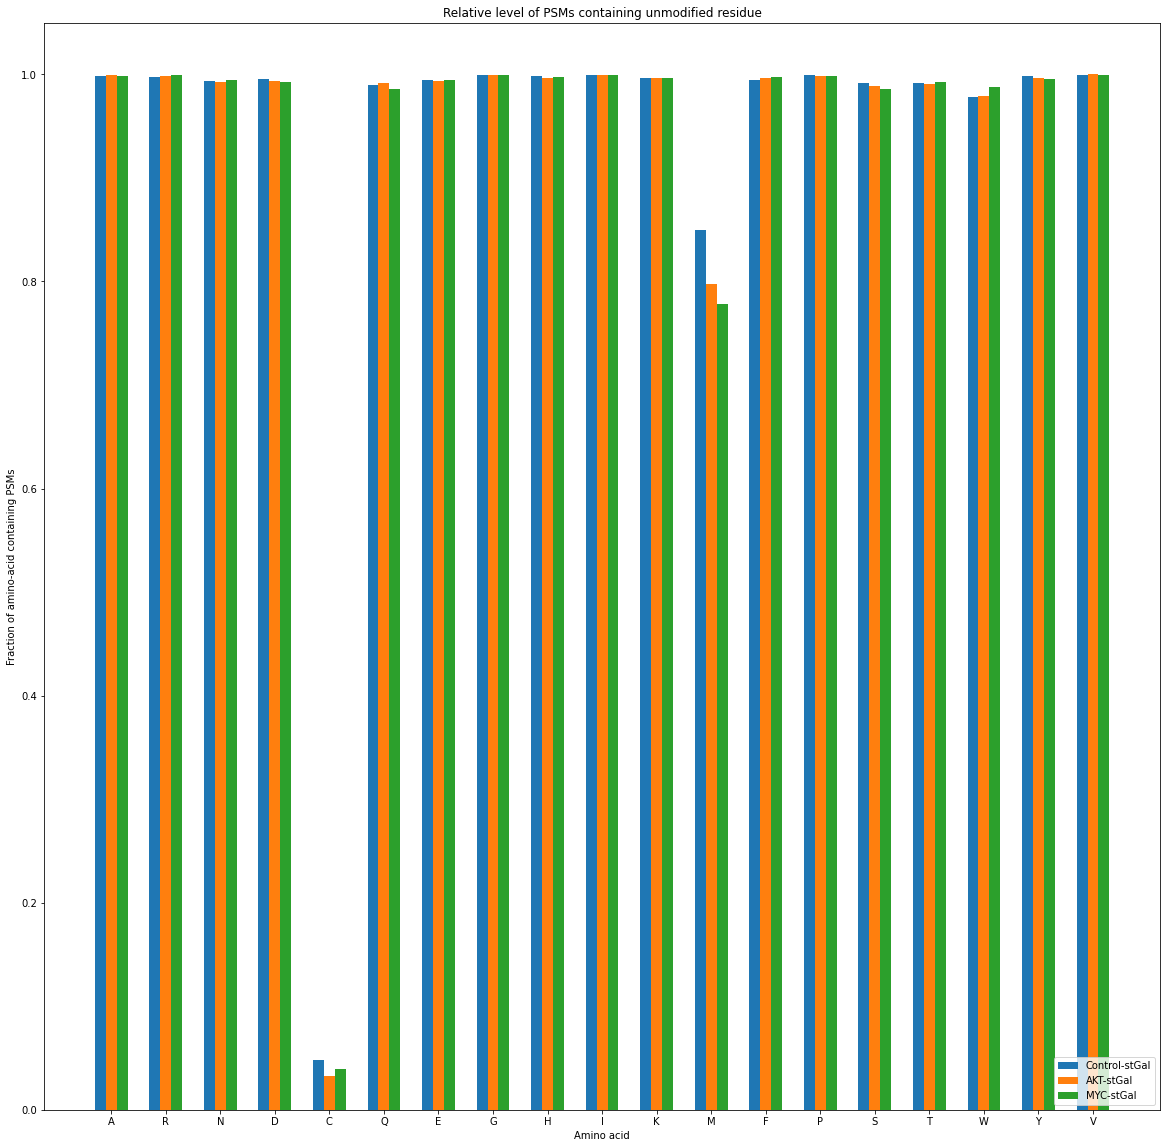

In [76]:
x = RPM5["Amino acid"]
xGlu = RPM5["Relative level of PSMs containing unmodified residue_Control"]
xst = RPM5['Relative level of PSMs containing unmodified residue_AKT']
xlt = RPM5['Relative level of PSMs containing unmodified residue_MYC']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Control-stGal')
plt.bar(x_axis, xst, 0.2, label = 'AKT-stGal')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'MYC-stGal')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

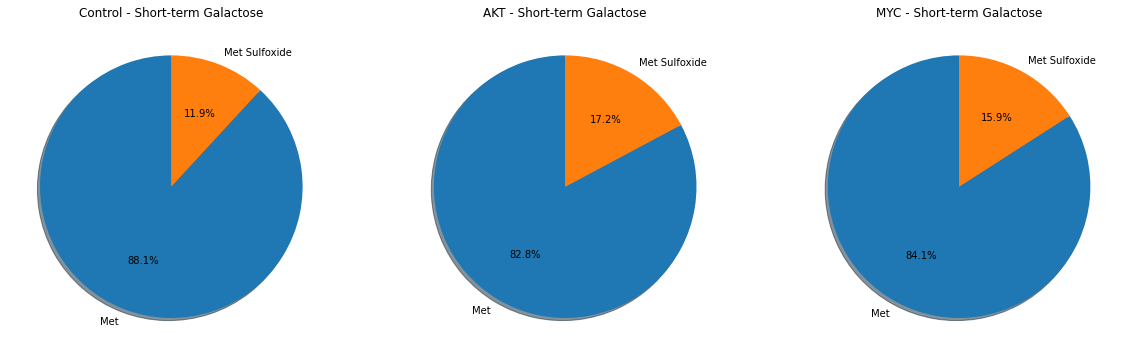

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Controlstrep, ax1)
OA.methionine_overview(AKTstrep, ax2)
OA.methionine_overview(MYCstrep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Control - Short-term Galactose")
ax2.set_title("AKT - Short-term Galactose")
ax3.set_title("MYC - Short-term Galactose")
plt.show()

### 6) Control, AKT and MYC in long-term Galactose

In [78]:
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlltrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: {}".format((AKTltrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: {}".format((MYCltrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 5.427662361968931 %
The ratio of PSMs that contain an oxidative modification in the AKT treatment subset: 3.004059539918809 %
The ratio of PSMs that contain an oxidative modification in the MYC treatment subset: 4.997550220480157 %


In [79]:
modr_temp6 = pd.merge(mrAKTltrep, mrMYCltrep, on="Modification", suffixes=('_AKT', '_MYC'))
modr6 = pd.merge(modr_temp6, mrControlltrep, on="Modification")
modr6 = modr6.rename(columns={'Ratios' : 'Ratios_Control'})
modr6 = modr6.drop(modr6[(modr6['Ratios_MYC'] == 0) | (modr6['Ratios_AKT'] == 0) | (modr6['Ratios_Control'] == 0)].index)
modr6

,Modification,Ratios_AKT,Ratios_MYC,Ratios_Control
0,[35]Oxidation[T],0.000209,0.000108,0.000179
1,[35]Oxidation[E],0.000089,0.000238,0.000209
2,[35]Oxidation[S],0.000268,0.000281,0.000507
3,[35]Oxidation[Q],0.000060,0.000043,0.000090
5,[35]Oxidation[I],0.000209,0.000389,0.000358
7,[35]Oxidation[G],0.000298,0.000194,0.000328
8,[35]Oxidation[W],0.000745,0.000971,0.002175
11,[35]Oxidation[V],0.000060,0.000151,0.000149
12,[35]Oxidation[R],0.000030,0.000043,0.000060
15,[35]Oxidation[F],0.000119,0.000324,0.000239


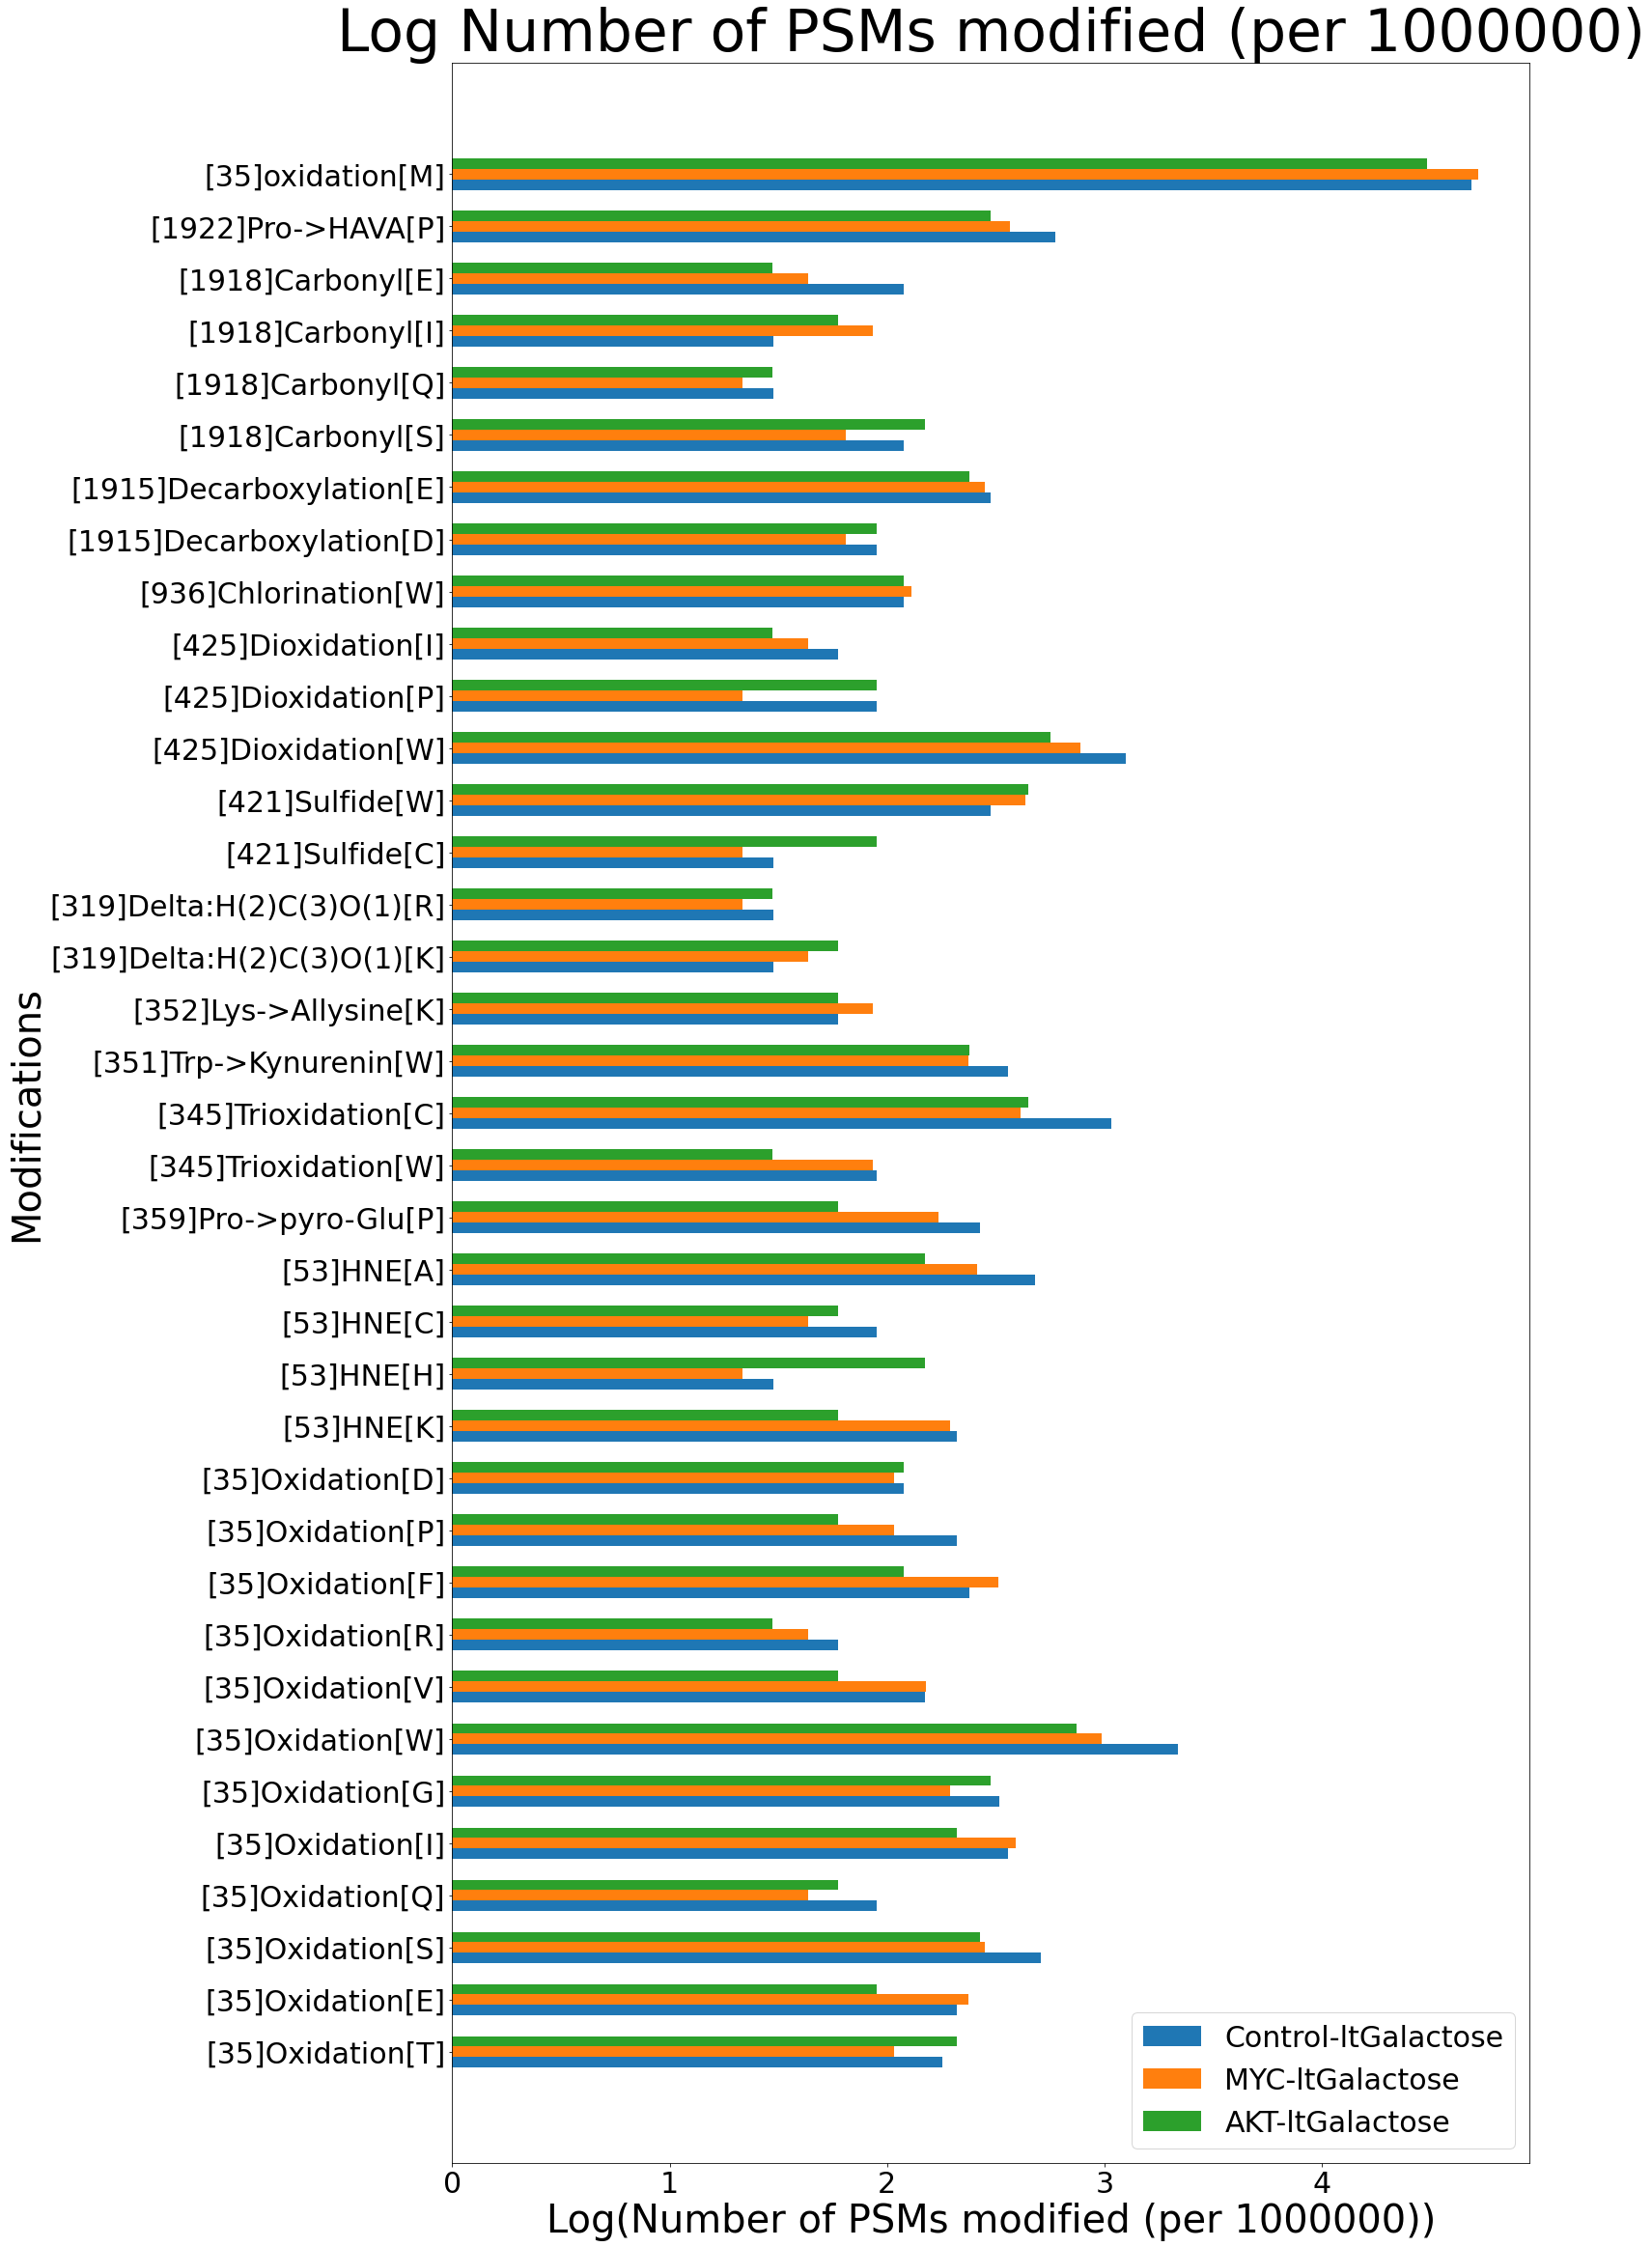

In [80]:
y = modr6["Modification"]
xGlu = np.log10(modr6['Ratios_Control']*1000000)
xstGal = np.log10(modr6['Ratios_MYC']*1000000)
xltGal = np.log10(modr6['Ratios_AKT']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'Control-ltGalactose')
plt.barh(y_axis, xstGal, 0.2, label = 'MYC-ltGalactose')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'AKT-ltGalactose')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

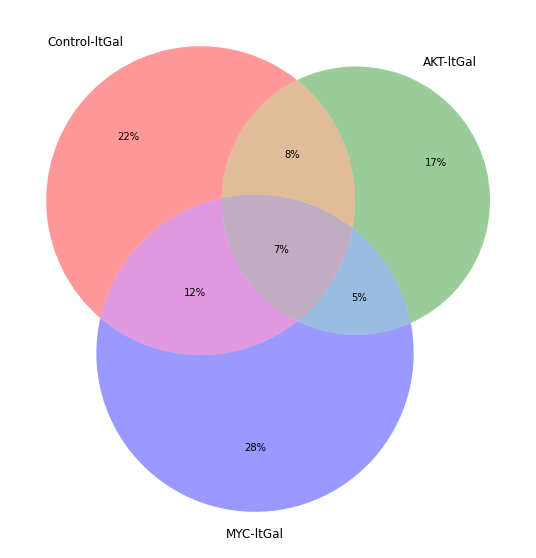

In [81]:
OA.condition_venn([Controlltrep,AKTltrep,MYCltrep], ["Control-ltGal", "AKT-ltGal", "MYC-ltGal"])

In [82]:
RPM6 = pd.merge(RPMControllt,RPMAKTlt, on="Amino acid", suffixes=('_Control','_AKT'))
RPM6 = pd.merge(RPM6, RPMMYClt, on="Amino acid")
RPM6 = RPM.rename(columns={"Relative level of PSMs containing unmodified residue": "Relative level of PSMs containing unmodified residue_MYC"})
RPM6

,Amino acid,Relative level of PSMs containing unmodified residue_Control,Relative level of PSMs containing unmodified residue_AKT,Relative level of PSMs containing unmodified residue_MYC
0,A,0.998433,0.998316,0.998165
1,R,0.997391,0.996830,0.996336
2,N,0.990915,0.989226,0.989766
3,D,0.993651,0.992172,0.992454
4,C,0.125770,0.025022,0.041919
5,Q,0.986634,0.990845,0.984909
6,E,0.996511,0.994979,0.991502
7,G,1.000000,0.998888,0.999331
8,H,0.996069,0.997434,0.998912
9,I,0.999700,0.999500,0.999219


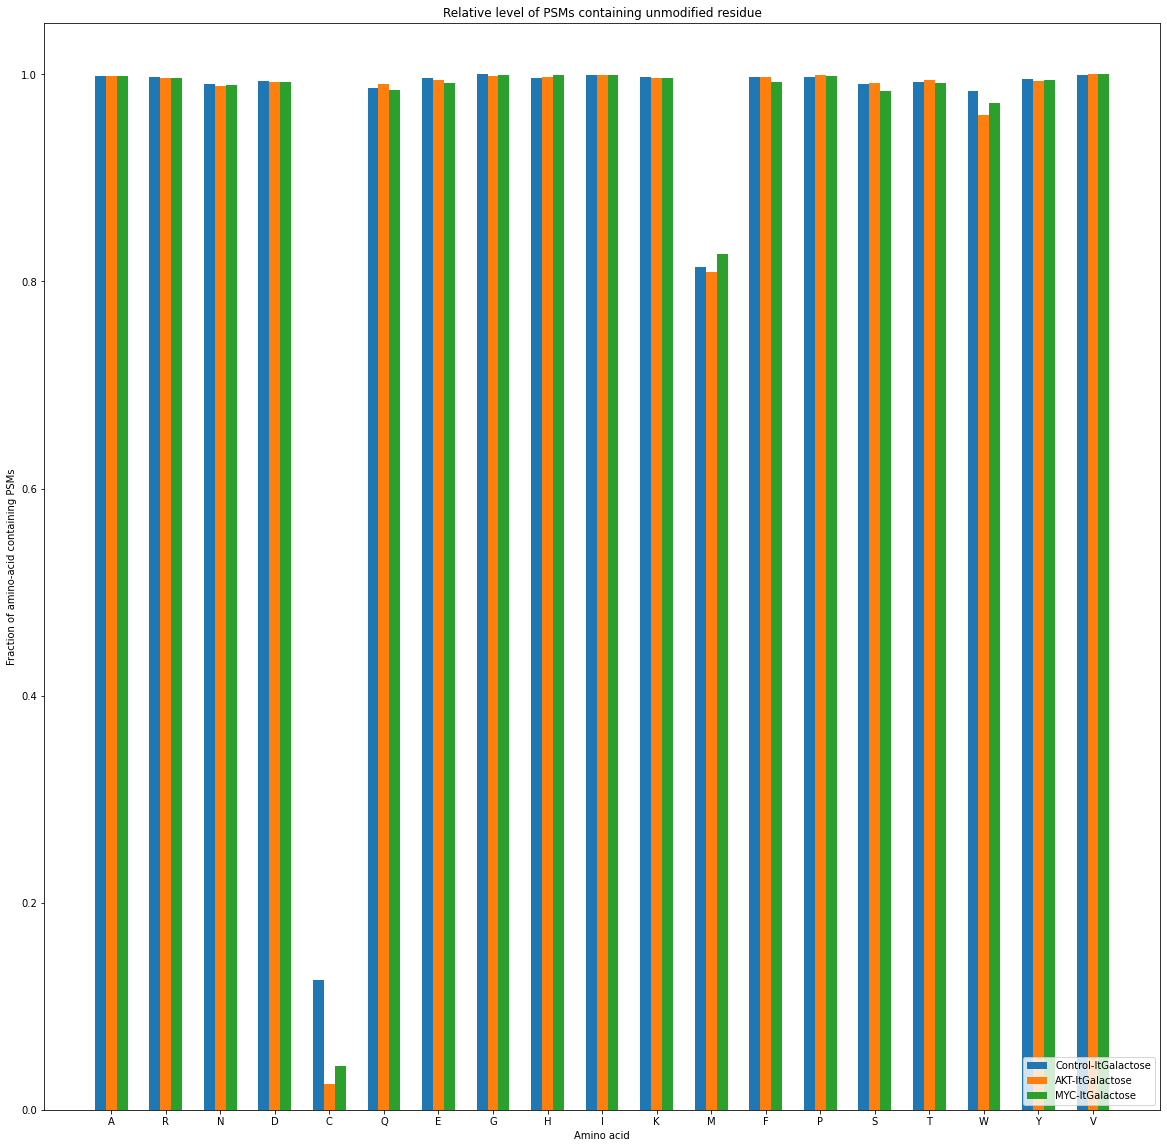

In [83]:
x = RPM6["Amino acid"]
xGlu = RPM6["Relative level of PSMs containing unmodified residue_Control"]
xst = RPM6['Relative level of PSMs containing unmodified residue_AKT']
xlt = RPM6['Relative level of PSMs containing unmodified residue_MYC']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Control-ltGalactose')
plt.bar(x_axis, xst, 0.2, label = 'AKT-ltGalactose')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'MYC-ltGalactose')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

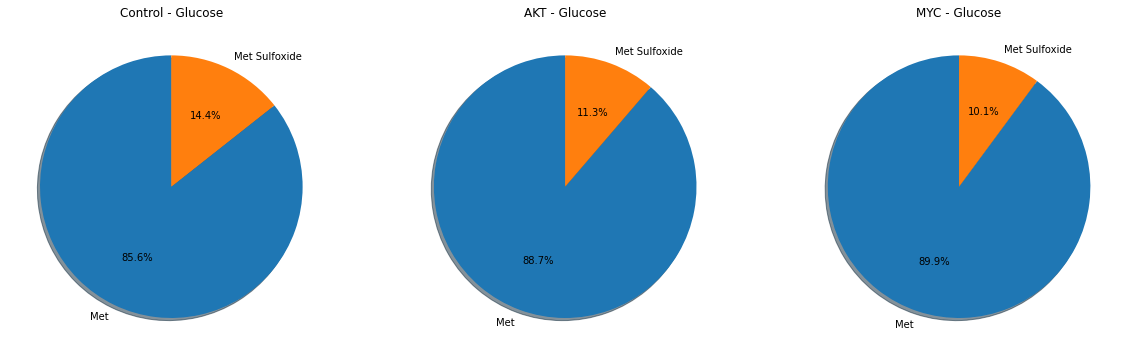

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Controlrep, ax1)
OA.methionine_overview(AKTrep, ax2)
OA.methionine_overview(MYCrep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Control - Glucose")
ax2.set_title("AKT - Glucose")
ax3.set_title("MYC - Glucose")
plt.show()

Contrast with short-term galactose!